In [79]:
import numpy as np
from numba import jit, prange
import matplotlib.pyplot as plt
import scipy
from scipy.fft import rfft, irfft, fftshift, ifftshift
from tqdm import tqdm

In [80]:
@jit(nopython=True, cache=True)
def _buffer(x, out, nfft, hop_len):
    for i in prange(0, x.shape[-1]-nfft+1, hop_len):
        out[:,:,i]=x[:,i:i+nfft]
def buffer(x, nfft, hop_len, modulated=True):
    # x: channel, time
    if np.ndim(x)==1:
        x = x.reshape(1,-1)
    out = np.zeros((x.shape[0], nfft, x.shape[-1]-nfft+1))
    _buffer(x, out, nfft, hop_len)
    if modulated:
        out = np.roll(out, int(np.ceil(nfft / 2)), 1)
    return out

@jit(nopython=True, cache=True)
def _unbuffer(x, xbuf, window, hop_len):
    for i in prange(xbuf.shape[2]):
        n = i * hop_len
        x[:, n:n + len(window)] += xbuf[:, :, i] * window
        
def unbuffer(xbuf, window, hop_len, win_exp=1):
    if np.ndim(xbuf)==2:
        xbuf=np.expand_dims(xbuf,0)
    if win_exp == 0:
        window = 1
    elif win_exp != 1:
        window = window ** win_exp
    x = np.zeros((xbuf.shape[0], xbuf.shape[1] + xbuf.shape[2] - 1), dtype=xbuf.dtype)

    _unbuffer(x, xbuf, window, hop_len)
    return x

@jit(nopython=True, cache=True)
def _window_norm(wn, window, hop_len, n_fft, win_exp=1):
    max_hops = (len(wn) - n_fft) // hop_len + 1
    wpow = window ** (win_exp + 1)
    for i in range(max_hops):
        n = i * hop_len
        wn[n:n + n_fft] += wpow

def window_norm(window, hop_len, n_fft, N, win_exp=1):
    wn = np.zeros(N + n_fft - 1)
    _window_norm(wn, window, hop_len, n_fft, win_exp)
    return wn

In [81]:
class VMD(object):
    def __init__(self, num_channel, n_fft= 128, alpha= 10, K= 3, init=1, tol=1e-05, tau= 0.1, maxiters=1000) -> None:
        self.alpha = alpha*np.ones(K)
        self.K=K
        self.n_fft = n_fft
        self.init=init
        self.tol=tol
        self.tau=tau
        self.maxiters = maxiters
        self.padwidth = ((n_fft-1)//2, (n_fft-1)//2) if (n_fft-1)%2==0 else ((n_fft-1)//2+1, (n_fft-1)//2)
        self.num_channel = num_channel
        self.u_hat_plus = None
        self.sum_uk = None
    
    def prepare_offline(self, x):
        assert np.ndim(x)<=2
        if np.ndim(x)==1:
            x = x.reshape(1, -1)
        self.len_x = x.shape[1]
        xp = np.pad(x, ([0, 0], self.padwidth), mode='reflect')
        f_hat_plus = rfft(xp, axis=1, workers=-1)
        return f_hat_plus
    
    def apply(self, f_hat_plus, omega=None):
        C, len_freqs = f_hat_plus.shape
        freqs = np.arange(1, len_freqs+1)/(len_freqs)
        omega_plus = np.zeros([self.maxiters, self.K])
        if omega is None:
            for i in range(self.K):
                omega_plus[0,i] = (1/self.K)*i
        else:
            omega_plus[0] = omega.ravel()
 
        u_hat_plus = np.zeros([self.maxiters, C, len_freqs, self.K],dtype=complex)
        sum_uk = np.zeros([C, len_freqs], dtype=complex)
        lambda_hat = np.zeros([self.maxiters, C, len_freqs], dtype = complex)
        
        pbar = tqdm(np.arange(self.maxiters-1))
        for iter in pbar:
            # n = np.mod(iter, 2)
            
            k = 0
            for c in np.arange(C):
                sum_uk[c,:] = u_hat_plus[np.mod(iter, 2), c,:,self.K-1] + sum_uk[c,:] - u_hat_plus[np.mod(iter, 2), c,:,0]
                u_hat_plus[np.mod(iter+1, 2), c,:,k] = (f_hat_plus[c, :] - sum_uk[c,:] - lambda_hat[np.mod(iter, 2), c,:]/2)/(1.+self.alpha[k]*(freqs - omega_plus[np.mod(iter, 2),k])**2)
            for k in np.arange(1,self.K):
                for c in np.arange(C):
                    sum_uk[c,:] = u_hat_plus[np.mod(iter+1, 2),c,:,k-1] + sum_uk[c,:] - u_hat_plus[np.mod(iter, 2),c,:,k]
                    u_hat_plus[np.mod(iter+1, 2),c,:,k] = (f_hat_plus[c,:] - sum_uk[c,:] - lambda_hat[np.mod(iter, 2),c,:]/2)/(1+self.alpha[k]*(freqs - omega_plus[np.mod(iter, 2),k])**2)
                # center frequencies
                if omega is not None:
                    omega_plus[np.mod(iter+1, 2),k] = omega_plus[0,k]
                else:
                    omega_plus[np.mod(iter+1, 2),k] = np.sum(np.einsum('j,ij', freqs,(abs(u_hat_plus[np.mod(iter+1, 2), :, :, k])**2)))/np.sum(abs(u_hat_plus[np.mod(iter+1, 2),:,:,k])**2)
            lambda_hat[np.mod(iter+1, 2),:,:] = lambda_hat[np.mod(iter, 2),:,:] + self.tau*(np.sum(u_hat_plus[np.mod(iter+1, 2),:,:,:],axis = 2)-f_hat_plus)

            uDiff = np.spacing(np.ones(self.K))
            for i in range(self.K):
                delta = u_hat_plus[0,:,i]-u_hat_plus[1,:,i]
                delta = delta.reshape(-1)
                uDiff[i] = (1/len(delta))*np.dot(delta,np.conj(delta)).real
            # for i in range(self.K):
            #     uDiff = uDiff + np.power(u_hat_plus[np.mod(iter, 2)]-u_hat_plus[np.mod(iter-1, 2)], 2).sum()/(len_freqs*self.K*C)
            uDiff = uDiff.mean(-1)
            if uDiff < self.tol and iter>2:
                break
            pbar.set_description("Processing "  + "{:10.9f}".format(uDiff) + ":")
        u_hat = u_hat_plus[np.mod(iter, 2)]
        omega = omega_plus[np.mod(iter, 2)]
        seqw = np.argsort(omega)
        u_hat = u_hat[:,:,seqw]
        omega = omega[seqw]
        return u_hat, omega
    
    def postprocess(self, u_hat):
        u = irfft(u_hat, n=self.len_x+np.sum(self.padwidth), axis=1, workers=-1).real
        u = np.transpose(u, (2, 0, 1))
        u = u[:, :, self.padwidth[0]:-self.padwidth[1]]
        return u

In [82]:
class STVMD(object):
    def __init__(self, num_channel, n_fft= 128, cache_size=None, window_func=None, alpha= 10, K= 3, init=1, tol=1e-05, tau= 0.1, win_exp=1, maxiters=1000) -> None:
        # n_fft: odd integers
        self.hop_len = 1
        self.n_fft = n_fft
        self.win_len = n_fft
        self.alpha = alpha*np.ones(K)
        self.freqs = np.arange(1, n_fft//2+2)/(n_fft//2+1)
        self.K=K
        self.win_exp = win_exp
        self.init=init
        self.tol=tol
        self.tau=tau
        self.padwidth = ((n_fft-1)//2, (n_fft-1)//2) if (n_fft-1)%2==0 else ((n_fft-1)//2+1, (n_fft-1)//2)
        if window_func is None:
            self.window = scipy.signal.windows.dpss(self.win_len, max(4, self.win_len//8), sym=False)
        else:
            self.window = window_func
        self.maxiters = maxiters

        self.num_channel = num_channel
        
        if cache_size is None:
            self.cache_size = self.n_fft
        else:
            self.cache_size = cache_size
        self.buffer_cache = np.zeros((self.num_channel, self.cache_size))# channel, F, T
        self.u_hat_cache = np.zeros((self.num_channel, len(self.freqs), self.K, self.cache_size)) # C, len(self.freqs), self.K, N
        self.u_hat_plus = None
        self.sum_uk = None
    
    def prepare_online(self, x):
        assert np.ndim(x)<=2
        if np.ndim(x)==1:
            x = x.reshape(-1, 1)
        print(x.shape)
        print(self.buffer_cache.shape)
        new_dims = x.shape[-1]
        self.buffer_cache = np.roll(self.buffer_cache, -new_dims, axis=1)
        self.buffer_cache[:,-new_dims:]=x
        xp = np.pad(self.buffer_cache, ([0, 0], [0, (self.n_fft-1)//2]), mode='reflect')
        print(xp.shape)
        Sx = buffer(xp, self.n_fft, self.hop_len, modulated=False)
        # Sx *= ifftshift(self.window, axes=0).reshape((1, -1, 1))
        Sx *= self.window.reshape((1, -1, 1))
        print(Sx.shape)
        f_hat_plus = rfft(Sx, axis=1, workers=-1)
        return f_hat_plus, Sx
    
    def prepare_offline(self, x):
        assert np.ndim(x)<=2
        if np.ndim(x)==1:
            x = x.reshape(1, -1)
        # assert x.shape[-1]>=self.n_fft
        xp = np.pad(x, ([0, 0], self.padwidth), mode='reflect')
        self.buffer_cache = xp[:, -self.n_fft//2+1-self.n_fft:-self.n_fft//2+1]
        Sx = buffer(xp, self.n_fft, self.hop_len, modulated=False)
        # Sx *= ifftshift(self.window, axes=0).reshape((1, -1, 1))
        Sx *= self.window.reshape((1, -1, 1))
        f_hat_plus = rfft(Sx, axis=1, workers=-1)
        return f_hat_plus, Sx
    
    def apply(self, f_hat_plus, omega=None, dynamic=False):
        if dynamic:
            u_hat, omega = self.apply_dynamic(f_hat_plus)
        else:
            u_hat, omega = self.apply_nodynamic(f_hat_plus, omega)
        return u_hat, omega
    
    def apply_nodynamic(self, f_hat_plus, omega=None, cached=False):
        C, _, N = f_hat_plus.shape
        omega_plus = np.zeros([self.maxiters, self.K])
        if omega is None:
            for i in range(self.K):
                omega_plus[0,i] = (1/self.K)*i
        else:
            omega_plus[0,:] = omega.reshape(-1,1)
        
        if cached:
            u_hat_plus = np.zeros([2, C, len(self.freqs), self.K, N],dtype=complex)
            u_hat_plus[0,:,:,:,:-1]=self.u_hat_cache[:,:,:,1:]
        else:
            u_hat_plus = np.zeros([2, C, len(self.freqs), self.K, N],dtype=complex)
        sum_uk = np.zeros([N, C, len(self.freqs)], dtype=complex)
        lambda_hat = np.zeros([2, C, len(self.freqs), N], dtype = complex)
        
        pbar = tqdm(np.arange(self.maxiters-1))
        for iter in pbar:
            # n = np.mod(iter, 2)
            
            k = 0
            for c in np.arange(C):
                for sw in np.arange(N):
                    sum_uk[sw,c,:] = u_hat_plus[np.mod(iter, 2), c,:,self.K-1,sw] + sum_uk[sw, c,:] - u_hat_plus[np.mod(iter, 2), c,:,0, sw]
                    u_hat_plus[np.mod(iter+1, 2), c,:,k, sw] = (f_hat_plus[c, :, sw] - sum_uk[sw, c,:] - lambda_hat[np.mod(iter, 2), c,:,sw]/2)/(1.+self.alpha[k]*(self.freqs - omega_plus[np.mod(iter, 2),k])**2)
            for k in np.arange(1,self.K):
                for sw in np.arange(N):
                    for c in np.arange(C):
                        #accumulator
                        sum_uk[sw,c,:] = u_hat_plus[np.mod(iter+1, 2),c,:,k-1,sw] + sum_uk[sw,c,:] - u_hat_plus[np.mod(iter, 2),c,:,k,sw]
                        # mode spectrum
                        u_hat_plus[np.mod(iter+1, 2),c,:,k,sw] = (f_hat_plus[c,:,sw] - sum_uk[sw,c,:] - lambda_hat[np.mod(iter, 2),c,:,sw]/2)/(1+self.alpha[k]*(self.freqs - omega_plus[np.mod(iter, 2),k])**2)
                # center frequencies
                if omega is not None:
                    omega_plus[np.mod(iter+1, 2),k] = omega_plus[0,k]
                else:
                    omega_plus[np.mod(iter+1, 2),k] = np.sum(np.einsum('j,ijk', self.freqs,(abs(u_hat_plus[np.mod(iter+1, 2), :, :, k, :])**2)))/np.sum(abs(u_hat_plus[np.mod(iter+1, 2),:,:,k,:])**2)
            lambda_hat[np.mod(iter+1, 2),:,:,:] = lambda_hat[np.mod(iter, 2),:,:,:] + self.tau*(np.sum(u_hat_plus[np.mod(iter+1, 2),:,:,:,:],axis = 2)-f_hat_plus)
            
            uDiff = np.spacing(np.ones((C, N, self.K)))
            for i in range(self.K):
                for c in range(C):
                    for n in range(N):
                        delta = u_hat_plus[0,c,:,i,n]-u_hat_plus[1,c,:,i, n]
                        delta = delta.reshape(-1)
                        uDiff[c,n,i] = (1/len(delta))*np.dot(delta,np.conj(delta)).real
            uDiff = uDiff.mean(-1)
            uDiff = uDiff.max()
            if uDiff < self.tol and iter>2:
                break
            pbar.set_description("Processing "  + "{:10.9f}".format(uDiff) + ":")
        u_hat = u_hat_plus[np.mod(iter, 2)]
        omega = omega_plus[np.mod(iter, 2)]
        self.u_hat_cache = u_hat_plus[np.mod(iter, 2), :, :, :, -self.cache_size:]
        seqw = np.argsort(omega)
        u_hat = u_hat[:,:,seqw,:]
        omega = omega[seqw]
        return u_hat, omega
    
    def apply_dynamic(self, f_hat_plus, cached=False):
        C, F, N = f_hat_plus.shape
        freqs = np.arange(1, F+1)/F# self.freqs
        omega_plus = np.zeros([self.maxiters, self.K, N])
        for i in range(self.K):
            omega_plus[0,i,:] = (1/self.K)*i
            
        if cached:
            u_hat_plus = np.zeros([2, C, len(freqs), self.K, N],dtype=complex)
            u_hat_plus[0,:,:,:,:-1]=self.u_hat_cache[:,:,:,1:]
        else:
            u_hat_plus = np.zeros([2, C, len(freqs), self.K, N],dtype=complex)
        sum_uk = np.zeros([N, C, len(freqs)], dtype=complex)
        lambda_hat = np.zeros([2, C, len(freqs), N], dtype = complex)
        
        pbar = tqdm(np.arange(self.maxiters-1))
        for iter in pbar:
            # n = np.mod(iter, 2)
            
            k = 0
            for c in np.arange(C):
                for sw in np.arange(N):
                    sum_uk[sw,c,:] = u_hat_plus[np.mod(iter, 2), c,:,self.K-1,sw] + sum_uk[sw, c,:] - u_hat_plus[np.mod(iter, 2), c,:,0, sw]
                    u_hat_plus[np.mod(iter+1, 2), c,:,k, sw] = (f_hat_plus[c, :, sw] - sum_uk[sw, c,:] - lambda_hat[np.mod(iter, 2), c,:,sw]/2)/(1.+self.alpha[k]*(freqs - omega_plus[np.mod(iter, 2),k, sw])**2)
            for k in np.arange(1,self.K):
                for sw in np.arange(N):
                    for c in np.arange(C):
                        #accumulator
                        sum_uk[sw,c,:] = u_hat_plus[np.mod(iter+1, 2),c,:,k-1,sw] + sum_uk[sw,c,:] - u_hat_plus[np.mod(iter, 2),c,:,k,sw]
                        # mode spectrum
                        
                        u_hat_plus[np.mod(iter+1, 2),c,:,k,sw] = (f_hat_plus[c,:,sw] - sum_uk[sw,c,:] - lambda_hat[np.mod(iter, 2),c,:,sw]/2)/(1+self.alpha[k]*(freqs - omega_plus[np.mod(iter, 2),k, sw])**2)
                        # center frequencies
                    omega_plus[np.mod(iter+1, 2),k,sw] = np.sum(np.einsum('j,ij', freqs,(abs(u_hat_plus[np.mod(iter+1, 2), :, :, k, sw])**2)))/np.sum(abs(u_hat_plus[np.mod(iter+1, 2),:,:,k,sw])**2)
            lambda_hat[np.mod(iter+1, 2),:,:,:] = lambda_hat[np.mod(iter, 2),:,:,:] + self.tau*(np.sum(u_hat_plus[np.mod(iter+1, 2),:,:,:,:],axis = 2)-f_hat_plus)
            uDiff = np.spacing(np.ones((C, N, self.K)))
            for i in range(self.K):
                for c in range(C):
                    for n in range(N):
                        delta = u_hat_plus[0,c,:,i,n]-u_hat_plus[1,c,:,i, n]
                        delta = delta.reshape(-1)
                        uDiff[c,n,i] = (1/len(delta))*np.dot(delta,np.conj(delta)).real
            uDiff = uDiff.mean(-1)
            uDiff = uDiff.max()
            if uDiff < self.tol and iter>2:
                break
            pbar.set_description("Processing "  + "{:10.9f}".format(uDiff) + ":")
        u_hat = u_hat_plus[np.mod(iter, 2)]
        self.u_hat_cache = u_hat_plus[np.mod(iter, 2), :, :, :, -self.cache_size:]
        omega = omega_plus[np.mod(iter, 2)]
        seqw = np.argsort(omega, axis=0)
        for n in range(N):
            u_hat[:,:,:,n] = u_hat[:,:,seqw[:,n],n]
            omega[:,n] = omega[seqw[:,n],n]
        return u_hat, omega
    
    def postprocess(self, u_hat):
        u = np.zeros([self.K, u_hat.shape[0], u_hat.shape[-1]+np.sum(self.padwidth)])
        wn = window_norm(self.window, self.hop_len, self.n_fft, u_hat.shape[-1], self.win_exp)
        for k in range(self.K):
            xbuf = irfft(u_hat[:,:,k,:], n=self.n_fft, axis=1, workers=-1).real
            # xbuf = fftshift(xbuf, axes=0)
            u[k,:,:] = unbuffer(xbuf, self.window, self.hop_len, self.win_exp)
        u = u/wn.reshape(1,1,-1)

        u = u[:, :, self.padwidth[0]:-self.padwidth[1]]
        return u

Stationary Signal with Fixed Frequencies

In [83]:
N = 256
fs = 128
t = np.arange(N)/fs
x1 = np.sin(2*np.pi*20*t)
x2 = 0.5*np.sin(2*np.pi*28*t)
np.random.seed(7)
f =x1+x2

In [84]:
N_fft = 64 # This is used for padding
N_imfs = 3
N_channels = 1
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=N_fft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

Processing 0.000000002::   0%|          | 8/9999 [00:00<00:07, 1394.67it/s]


In [85]:
nfft=64
window_func = scipy.signal.windows.hamming(nfft, sym=True)
stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_s, b_hat_s = stmd.prepare_offline(f)
u_hat_s, w_hat_s = stmd.apply(f_hat_s, dynamic=False)
imf_stvmd = stmd.postprocess(u_hat_s)

Processing 0.000000001::   0%|          | 28/9999 [00:00<01:59, 83.53it/s]


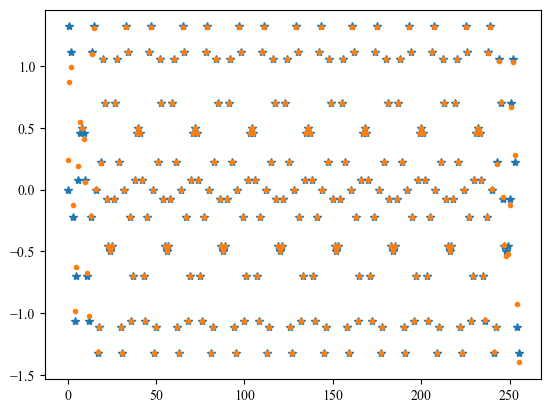

In [86]:
plt.plot(f, '*')
plt.plot(imf_vmd.sum(0).reshape(-1), '.')


In [87]:
imf_stvmds_nd = []
f_hat = []
imf_stvmds_nd.append(imf_vmd)
w_hat_s_nd = []
N_fft = [8, 16, 32, 64, 128, 256]
for idx, nfft in enumerate(N_fft):
    window_func = scipy.signal.windows.hamming(nfft, sym=True)
    # window_func = scipy.signal.windows.hann(nfft, sym=False)
    stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
    f_hat_s, b_hat_s = stmd.prepare_offline(f)
    f_hat.append(f_hat_s)
    u_hat_s, w_hat_s = stmd.apply(f_hat_s, dynamic=False)
    w_hat_s_nd.append(w_hat_s)
    imf_stvmd = stmd.postprocess(u_hat_s)
    imf_stvmds_nd.append(imf_stvmd)

Processing 0.000000001::   0%|          | 24/9999 [00:00<03:08, 52.79it/s]


In [88]:
imf_stvmds_d = []
imf_stvmds_d.append(imf_vmd)
w_hat_s_d = []
f_hat = []
imf_stvmds_d.append(imf_vmd)
N_fft = [8, 16, 32, 64, 128, 256]
for idx, nfft in enumerate(N_fft):
    window_func = scipy.signal.windows.hamming(nfft, sym=True)
    # window_func = scipy.signal.windows.hann(nfft, sym=False)
    stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
    f_hat_s, b_hat_s = stmd.prepare_offline(f)
    f_hat.append(f_hat_s)
    u_hat_s, w_hat_s = stmd.apply(f_hat_s, dynamic=True)
    w_hat_s_d.append(w_hat_s)
    imf_stvmd = stmd.postprocess(u_hat_s)
    imf_stvmds_d.append(imf_stvmd)

Processing 0.000000002::   0%|          | 24/9999 [00:00<03:56, 42.19it/s]


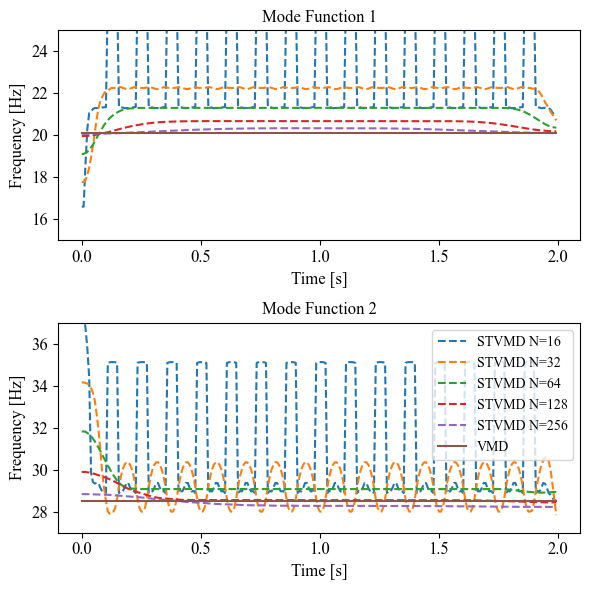

In [89]:
fontsize=12
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
lim = [[15, 25], [27, 37]]
N_fft = [8, 16, 32, 64, 128, 256]
for j in range(2):
    for i in range(5):
        axs[j].plot(w_hat_s_d[i+1][j+1].T*64,'--', label=f'STVMD N={N_fft[i+1]}', alpha=1.0)
    axs[j].plot(w_hat_v.reshape(1,-1)[0,j+1]*np.ones((256, 1))*64, '-', label='VMD')
    axs[j].set_xticks(np.arange(0, N+1, fs/2))
    axs[j].set_ylim(lim[j][0], lim[j][1])
    axs[j].set_xticklabels(np.arange(0, N+1, fs/2)/fs)
    axs[j].set_xlabel('Time [s]', fontsize=fontsize)
    axs[j].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    axs[j].tick_params(axis='both', which='major', labelsize=fontsize)
    axs[j].set_title(f'Mode Function {j+1}', fontsize=fontsize)
plt.legend(ncol=1, fontsize=10,loc='upper right')
plt.tight_layout()
plt.show()

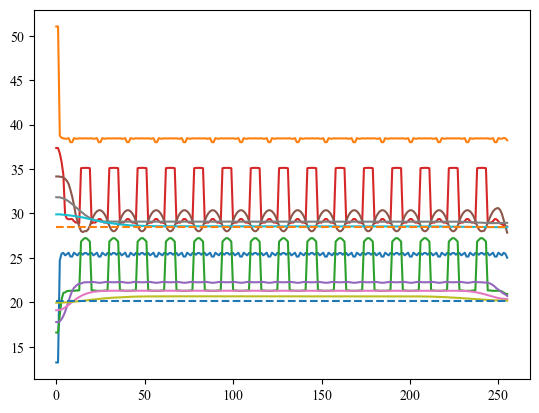

In [90]:
for i in range(5):
    plt.plot(w_hat_s_d[i][1:].T*64)
plt.plot(w_hat_v.reshape(1,-1)[0,1:]*np.ones((256, 1))*64, '--')

In [91]:
N = 256
fs = 128
t = np.arange(N)/fs
x1 = np.sin(2*np.pi*20*t)
x2 = 0.5*np.sin(2*np.pi*28*t)
np.random.seed(7)
f =x1+x2

In [92]:
fontsize = 11

In [93]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']


In [94]:
N_fft = 64 # This is used for padding
N_imfs = 3
N_channels = 1
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=N_fft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

Processing 0.000000002::   0%|          | 8/9999 [00:00<00:07, 1347.62it/s]


In [95]:
imf_stvmds = []
f_hat = []
imf_stvmds.append(imf_vmd)
w_hat_s = []
alpha=50
N_fft = [16, 32, 64, 128]
for idx, nfft in enumerate(N_fft):
    window_func = scipy.signal.windows.hamming(nfft, sym=False)
    # window_func = scipy.signal.windows.hann(nfft, sym=False)
    stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
    f_hat_s, b_hat_s = stmd.prepare_offline(f)
    f_hat.append(f_hat_s)
    u_hat_s, w_hat_s = stmd.apply(f_hat_s, dynamic=False)
    imf_stvmd = stmd.postprocess(u_hat_s)
    imf_stvmds.append(imf_stvmd)

Processing 0.000000001::   0%|          | 25/9999 [00:00<02:13, 74.97it/s]


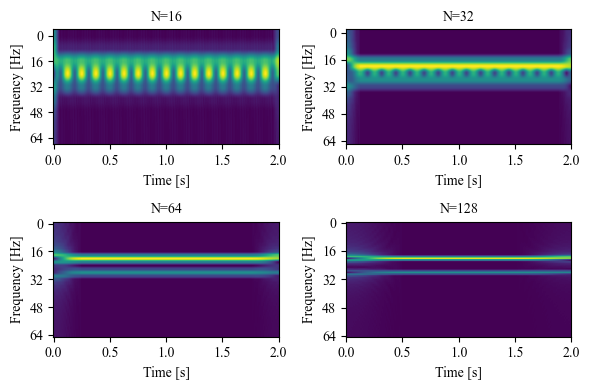

In [96]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
fontsize=10
k = 0
for i in range(2):
    for j in range(2):
        axs[i,j].imshow(np.abs(f_hat[k][0]), aspect='auto')
        axs[i,j].set_xticks(np.arange(0, N+1, fs/2))
        axs[i,j].set_xticklabels(np.arange(0, N+1, fs/2)/fs)
        axs[i,j].set_yticks(np.arange(0, N_fft[k]/2+1, N_fft[k]/8))
        axs[i,j].set_yticklabels(np.int64(np.arange(0, N_fft[k]/2+1, N_fft[k]/8)/N_fft[k]*fs))
        axs[i,j].set_xlabel('Time [s]', fontsize=fontsize)
        axs[i,j].set_ylabel('Frequency [Hz]', fontsize=fontsize)
        axs[i,j].tick_params(axis='both', which='major', labelsize=fontsize)
        axs[i,j].set_title(f'N={N_fft[k]}', fontsize=fontsize)
        k=k+1
plt.tight_layout()
plt.show()

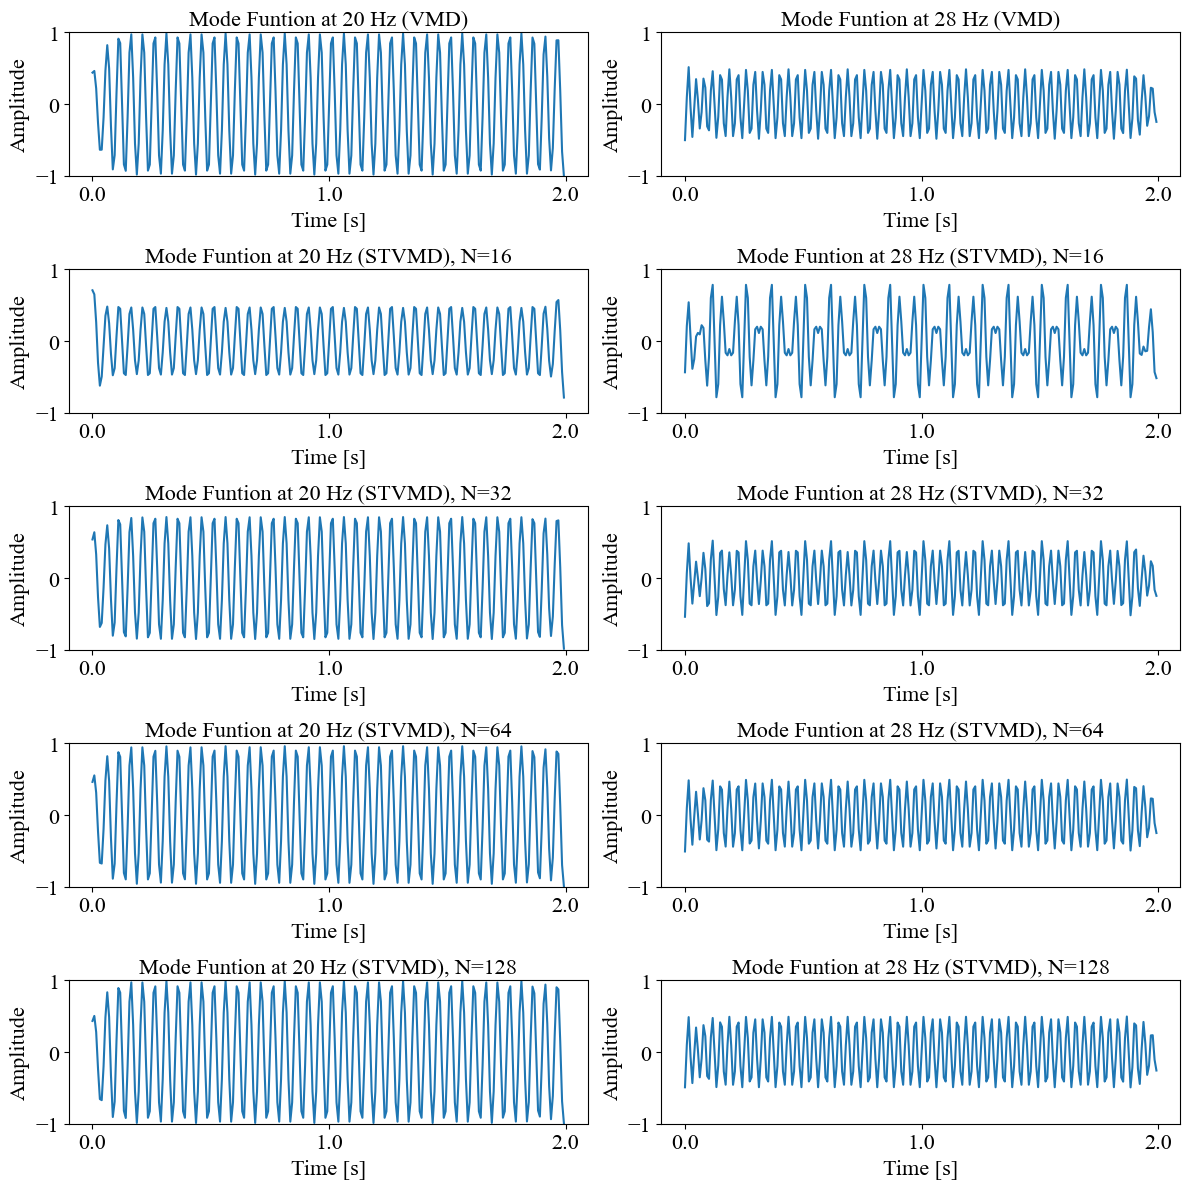

In [97]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))
lim=1
fontsize=16
freq = [20, 28]
for i in np.arange(0, 5):
    for j in np.arange(2):
        axs[i,j].plot(imf_stvmds[i][j+1, 0, :], label='STVMD')
        axs[i,j].set_xticks(np.arange(0, N+1, fs))
        axs[i,j].set_xticklabels(np.arange(0, N+1, fs)/fs)
        axs[i,j].set_ylim((-lim,lim))
        axs[i,j].set_xlabel('Time [s]', fontsize=fontsize)
        axs[i,j].set_ylabel('Amplitude', fontsize=fontsize)
        axs[i,j].tick_params(axis='both', which='major', labelsize=fontsize)
        if i==0:
            axs[i,j].set_title(f'Mode Funtion at {freq[j]} Hz (VMD)', fontsize=fontsize)
        else:
            axs[i,j].set_title(f'Mode Funtion at {freq[j]} Hz (STVMD), N={N_fft[i-1]}', fontsize=fontsize)
        
# Display the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()


In [98]:
N = 256
fs = 128
t = np.arange(N)/fs
x1 = 1*np.sin(2*np.pi*20*t)
x2 = 0.5*np.sin(2*np.pi*28*t)
x3 = 0.5*np.sin(2*np.pi*36*t)
f1 =x1+x3
f2 =x2+x3
f = np.concatenate((f1.reshape(1,-1), f2.reshape(1,-1)), axis=0)

In [99]:
N_fft = 64 # This is used for padding
N_imfs = 4
N_channels = 2
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=N_fft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

Processing 0.000000008::   0%|          | 13/9999 [00:00<00:09, 1068.36it/s]


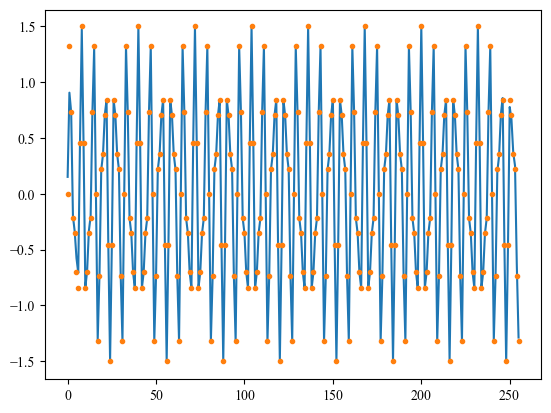

In [100]:
plt.plot(imf_vmd[:,0,:].sum(0).T)
plt.plot(f[0].T, '.')

In [101]:
imf_stvmds = []
f_hat = []
imf_stvmds.append(imf_vmd)
N_fft = [16, 32, 64, 128, 256]
for idx, nfft in enumerate(N_fft):
    window_func = scipy.signal.windows.hamming(nfft, sym=False)
    stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
    f_hat_s, b_hat_s = stmd.prepare_offline(f)
    f_hat.append(f_hat_s)
    u_hat_s, w_hat_s = stmd.apply(f_hat_s, dynamic=False)
    imf_stvmd = stmd.postprocess(u_hat_s)
    imf_stvmds.append(imf_stvmd)

Processing 0.000000001::   0%|          | 27/9999 [00:01<08:08, 20.41it/s]


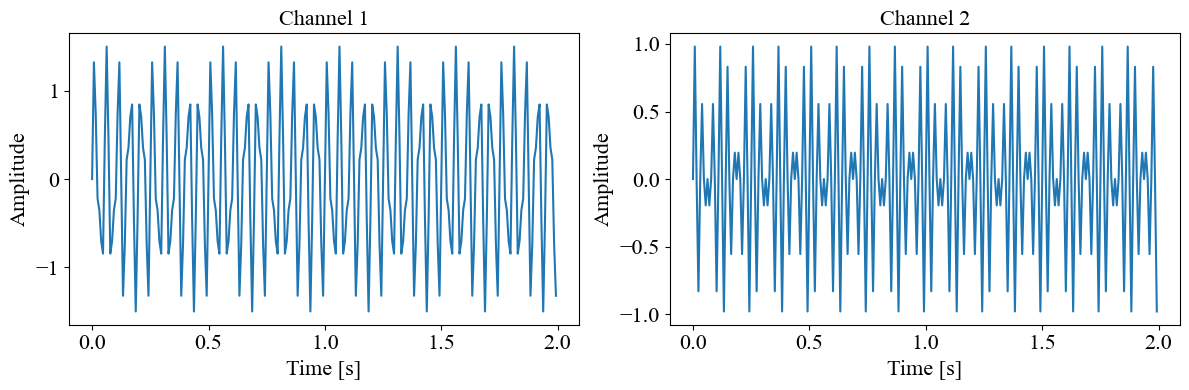

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fontsize=16
for j in range(2):
    axs[j].plot(f[j])
    axs[j].set_xticks(np.arange(0, N+1, fs/2))
    axs[j].set_xticklabels(np.arange(0, N+1, fs/2)/fs)
    axs[j].set_xlabel('Time [s]', fontsize=fontsize)
    axs[j].set_ylabel('Amplitude', fontsize=fontsize)
    axs[j].tick_params(axis='both', which='major', labelsize=fontsize)
    axs[j].set_title(f'Channel {j+1}', fontsize=fontsize)
plt.tight_layout()
plt.show()

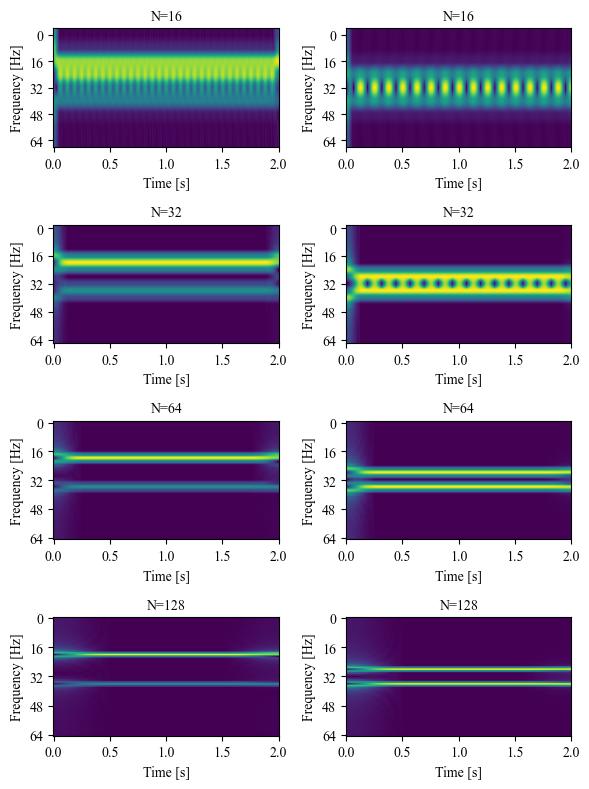

In [103]:
fig, axs = plt.subplots(4, 2, figsize=(6, 8))
N_fft = [16, 32, 64, 128, 256]
k = 0
fontsize=10
for i in range(4):
    for j in range(2):
        axs[i,j].imshow(np.abs(f_hat[i][j]), aspect='auto')
        axs[i,j].set_xticks(np.arange(0, N+1, fs/2))
        axs[i,j].set_xticklabels(np.arange(0, N+1, fs/2)/fs)
        axs[i,j].set_yticks(np.arange(0, N_fft[k]/2+1, N_fft[k]/8))
        axs[i,j].set_yticklabels(np.int64(np.arange(0, N_fft[k]/2+1, N_fft[k]/8)/N_fft[k]*fs))
        axs[i,j].set_xlabel('Time [s]', fontsize=fontsize)
        axs[i,j].set_ylabel('Frequency [Hz]', fontsize=fontsize)
        axs[i,j].tick_params(axis='both', which='major', labelsize=fontsize)
        axs[i,j].set_title(f'N={N_fft[k]}', fontsize=fontsize)
    k=k+1
plt.tight_layout()
plt.show()

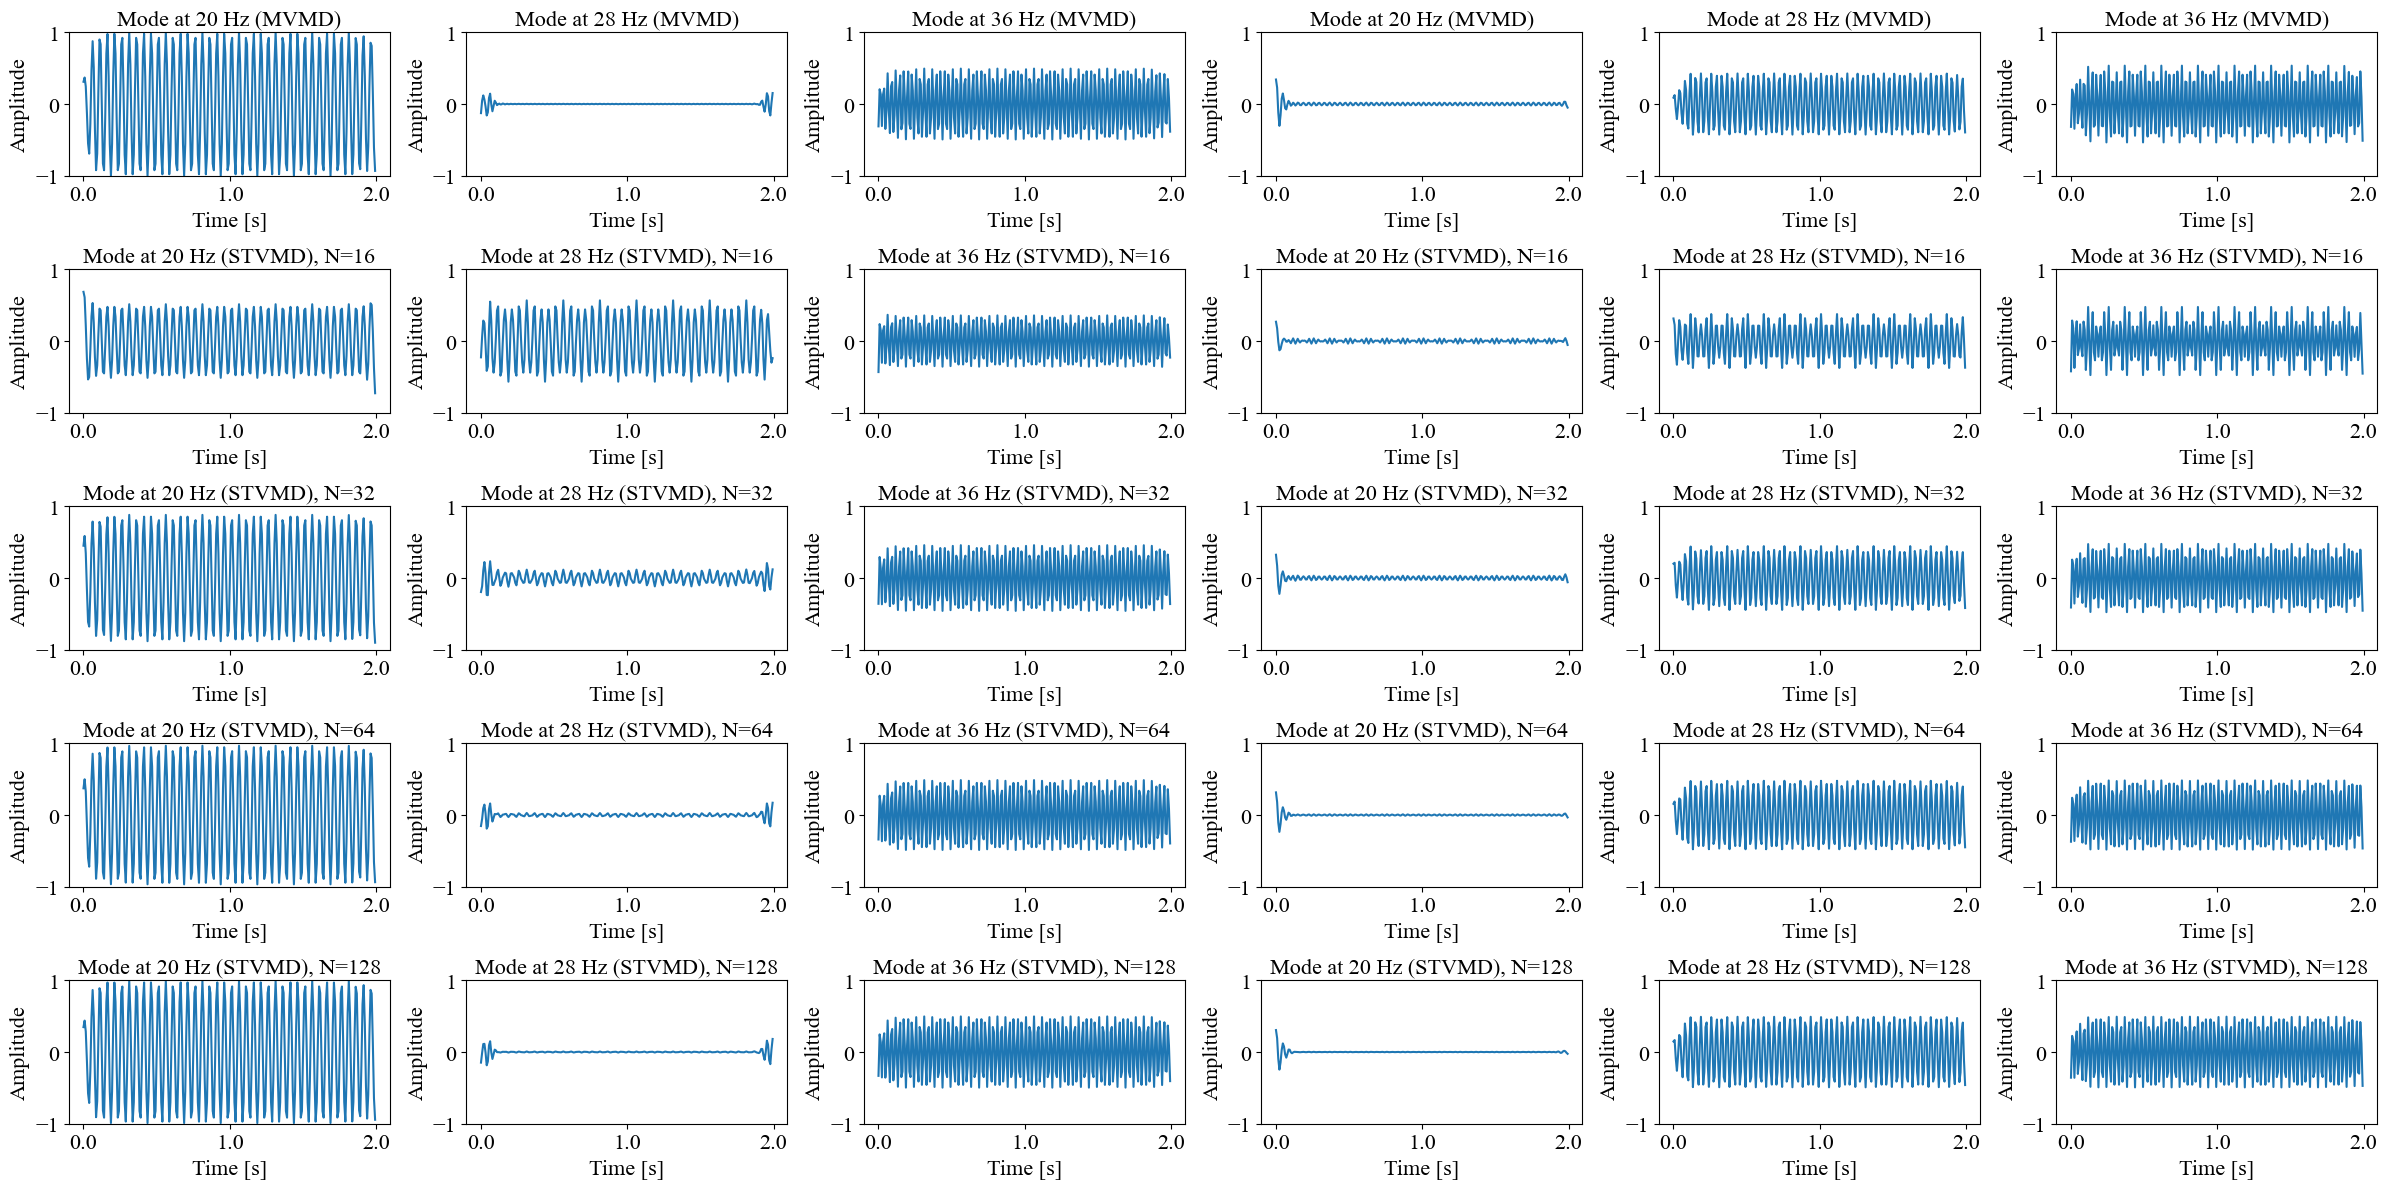

In [104]:
fig, axs = plt.subplots(5, 6, figsize=(24, 12))
lim=1
fontsize=16
freq = [20, 28, 36]
for i in np.arange(0, 5):
    for j in np.arange(3):
        axs[i,j].plot(imf_stvmds[i][j+1, 0, :], label='STVMD')
        axs[i,j].set_xticks(np.arange(0, 2*fs+1, fs))
        axs[i,j].set_xticklabels(np.arange(0, 2*fs+1, fs)/fs)
        axs[i,j].set_ylim((-lim,lim))
        axs[i,j].set_xlabel('Time [s]', fontsize=fontsize)
        axs[i,j].set_ylabel('Amplitude', fontsize=fontsize)
        axs[i,j].tick_params(axis='both', which='major', labelsize=fontsize)
        if i==0:
            axs[i,j].set_title(f'Mode at {freq[j]} Hz (MVMD)', fontsize=fontsize)
        else:
            axs[i,j].set_title(f'Mode at {freq[j]} Hz (STVMD), N={N_fft[i-1]}', fontsize=fontsize)

        axs[i,j+3].plot(imf_stvmds[i][j+1, 1, :], label='STVMD')
        axs[i,j+3].set_xticks(np.arange(0, 2*fs+1, fs))
        axs[i,j+3].set_xticklabels(np.arange(0, 2*fs+1, fs)/fs)
        axs[i,j+3].set_ylim((-lim,lim))
        axs[i,j+3].set_xlabel('Time [s]', fontsize=fontsize)
        axs[i,j+3].set_ylabel('Amplitude', fontsize=fontsize)
        axs[i,j+3].tick_params(axis='both', which='major', labelsize=fontsize)
        if i==0:
            axs[i,j+3].set_title(f'Mode at {freq[j]} Hz (MVMD)', fontsize=fontsize)
        else:
            axs[i,j+3].set_title(f'Mode at {freq[j]} Hz (STVMD), N={N_fft[i-1]}', fontsize=fontsize)
        
        
# Display the plots
plt.tight_layout()
plt.show()


Comparison between non-dynamic and dynamic STVMD

In [105]:
N = 256
fs = 128
t = np.arange(N)/fs
x1 = np.sin(2*np.pi*20*t)
x2 = 0.5*np.sin(2*np.pi*28*t)
np.random.seed(7)
f =x1+x2

Processing 0.000000001::   0%|          | 28/9999 [00:00<02:03, 81.03it/s]


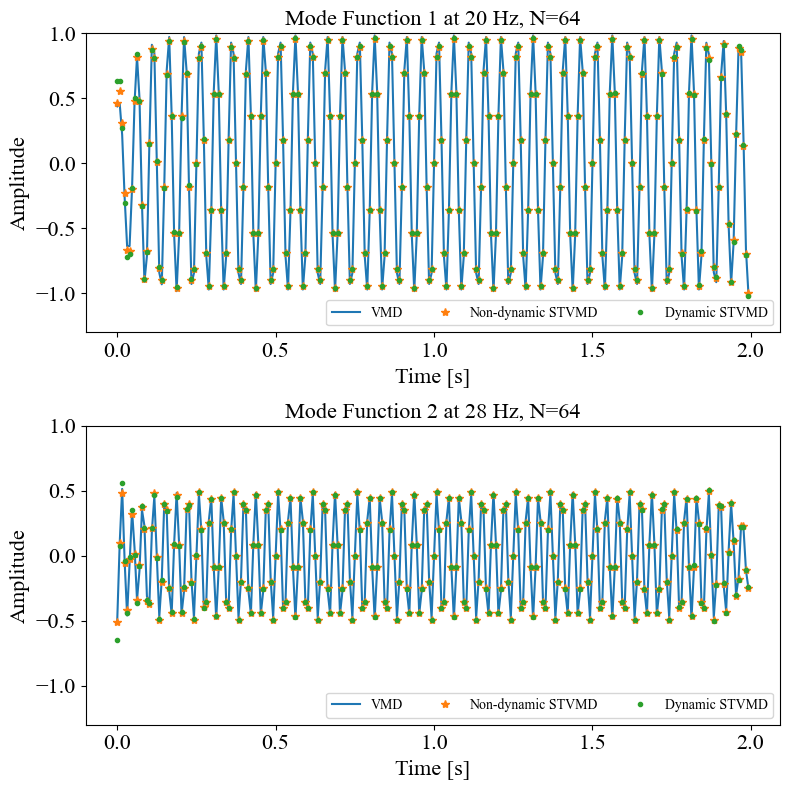

In [106]:
imf_stvmd_d = []
imf_stvmd_nd = []
f_hat = []
nfft = 64
N_imfs = 3
N_channels = 2
freqs=[20, 28]
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=64, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

window_func = scipy.signal.windows.hamming(nfft, sym=False)
stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_s, b_hat_s = stmd.prepare_offline(f)
u_hat_d, w_hat_d = stmd.apply(f_hat_s, dynamic=True)
imf_stvmd_d = stmd.postprocess(u_hat_d)
u_hat_nd, w_hat_nd = stmd.apply(f_hat_s, dynamic=False)
imf_stvmd_nd = stmd.postprocess(u_hat_nd)

fontsize=16
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
for j in range(2):
    axs[j].plot(imf_vmd[j+1,0,:].T, '-', label='VMD')
    axs[j].plot(imf_stvmd_nd[j+1,0,:].T, '*', label='Non-dynamic STVMD')
    axs[j].plot(imf_stvmd_d[j+1,0,:].T, '.',  label='Dynamic STVMD')
    axs[j].set_ylim(-1.3, 1.0)
    axs[j].set_xticks(np.arange(0, N+1, fs/2))
    axs[j].set_xticklabels(np.arange(0, N+1, fs/2)/fs)
    axs[j].set_xlabel('Time [s]', fontsize=fontsize)
    axs[j].set_ylabel('Amplitude', fontsize=fontsize)
    axs[j].tick_params(axis='both', which='major', labelsize=fontsize)
    axs[j].set_title(f'Mode Function {j+1} at {freqs[j]} Hz, N=64', fontsize=fontsize)
    axs[j].legend(loc='lower right',ncol=3)
plt.tight_layout()
plt.show()

In [107]:
imf_stvmd_d = []
imf_stvmd_nd = []
f_hat = []
# nfft = 64
N_imfs = 3
N_channels = 2
freqs=[20, 28]
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=64, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

imf_stvmds_d = []
imf_stvmds_nd= []
w_hats_d = []
w_hats_nd= []
for nfft in [16,32,64,128]:
    window_func = scipy.signal.windows.hamming(nfft, sym=False)
    stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
    f_hat_s, b_hat_s = stmd.prepare_offline(f)
    u_hat_d, w_hat_d = stmd.apply(f_hat_s, dynamic=True)
    imf_stvmd_d = stmd.postprocess(u_hat_d)
    imf_stvmds_d.append(imf_stvmd_d)
    w_hats_d.append(w_hat_d)
    u_hat_nd, w_hat_nd = stmd.apply(f_hat_s, dynamic=False)
    imf_stvmd_nd = stmd.postprocess(u_hat_nd)
    imf_stvmds_nd.append(imf_stvmd_nd)
    w_hats_nd.append(w_hat_nd)

Processing 0.000000001::   0%|          | 25/9999 [00:00<02:07, 78.51it/s]


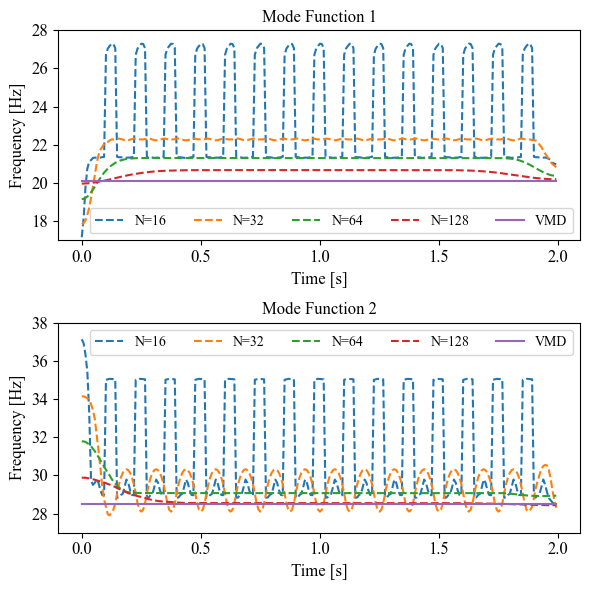

In [108]:
fontsize=12
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
lim = [[17, 28], [27, 38]]
N_fft = [16, 32, 64, 128]
for j in range(2):
    for i in range(4):
        axs[j].plot(w_hats_d[i][j+1].T*64,'--', label=f'N={N_fft[i]}', alpha=1.0)
    axs[j].plot(w_hat_v.reshape(1,-1)[0,j+1]*np.ones((256, 1))*64, '-', label='VMD')
    axs[j].set_xticks(np.arange(0, N+1, fs/2))
    axs[j].set_ylim(lim[j][0], lim[j][1])
    axs[j].set_xticklabels(np.arange(0, N+1, fs/2)/fs)
    axs[j].set_xlabel('Time [s]', fontsize=fontsize)
    axs[j].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    axs[j].tick_params(axis='both', which='major', labelsize=fontsize)
    axs[j].set_title(f'Mode Function {j+1}', fontsize=fontsize)
axs[0].legend(ncol=5, fontsize=10,loc='lower right')
axs[1].legend(ncol=5, fontsize=10,loc='upper right')
plt.tight_layout()
plt.show()

In [109]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
fontsize=11

In [110]:
N = 1024
fs = 128
t = np.arange(N)/fs
np.random.seed(7)
seq = np.random.permutation(np.arange(8))
def omega(t):
    return seq[np.floor(t).astype(int)]+13
x1 = np.sin(2*np.pi*(omega(t))*t)
x2 = 0.5*np.sin(2*np.pi*(2*omega(t))*t)

f =x1+x2+np.random.randn(N)*0.2

In [111]:
seq

array([2, 5, 0, 6, 3, 1, 4, 7])

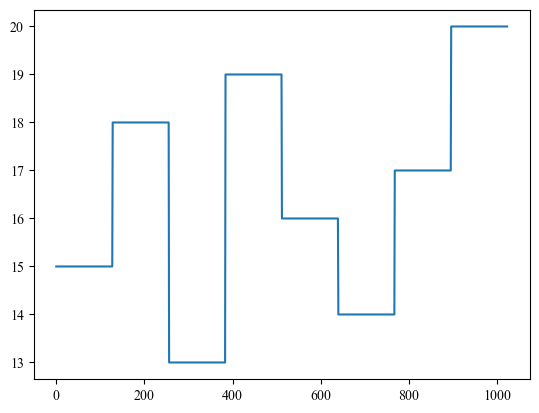

In [112]:
plt.plot(omega(t))

In [113]:
imf_stvmd_d = []
imf_stvmd_nd = []
f_hat = []
nfft = 64
N_imfs = 3
N_channels = 1
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=64, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

window_func = scipy.signal.windows.hamming(nfft, sym=False)
stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_s, b_hat_s = stmd.prepare_offline(f)
u_hat_d, w_hat_d = stmd.apply(f_hat_s, dynamic=True)
imf_stvmd_d = stmd.postprocess(u_hat_d)
u_hat_nd, w_hat_nd = stmd.apply(f_hat_s, dynamic=False)
imf_stvmd_nd = stmd.postprocess(u_hat_nd)

Processing 0.000000002::   0%|          | 28/9999 [00:01<07:11, 23.11it/s]


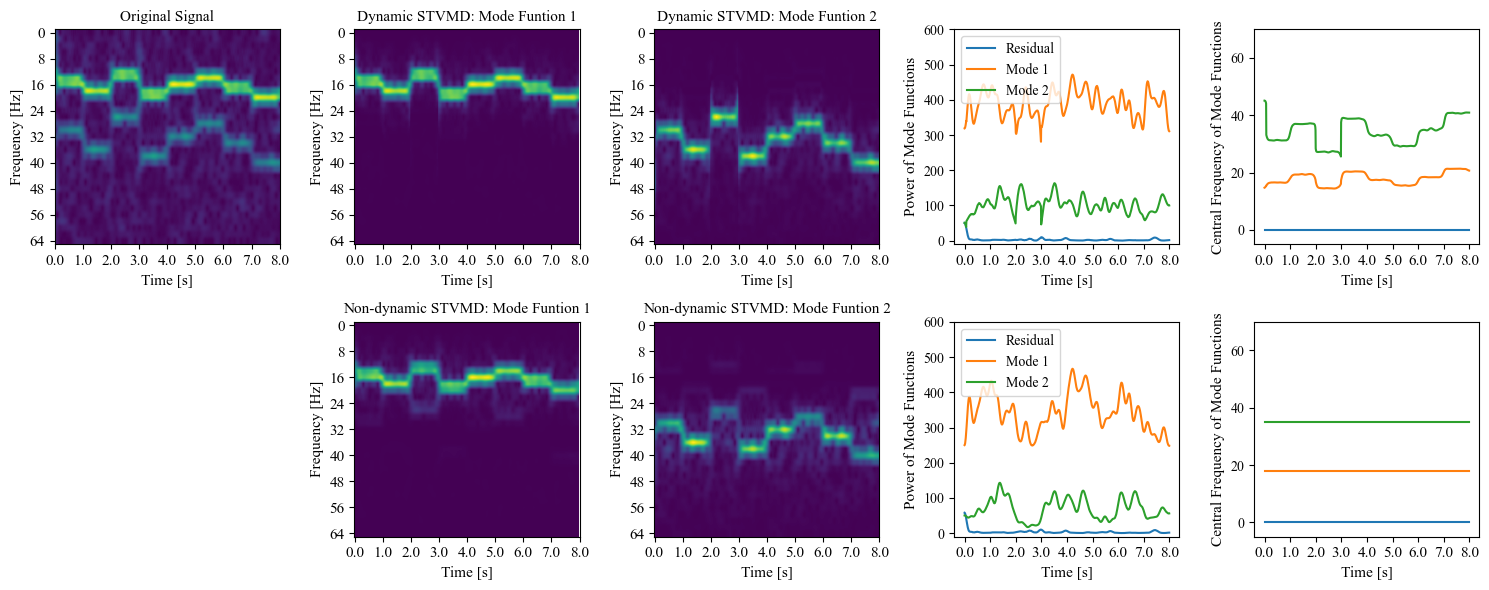

In [114]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
p_end = 33
p_step=4
scale=2
fontsize = 11
axs[0, 0].imshow(np.abs(f_hat_s[0,:p_end,:]), aspect='auto')
axs[0, 0].set_xticks(np.arange(0, N+1, fs))
axs[0, 0].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 0].set_yticks(np.arange(0, p_end, p_step))
axs[0, 0].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
axs[0, 0].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 0].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[0, 0].set_title('Original Signal', fontsize=fontsize)

for idx in range(2):
    i = idx+1
    axs[0, i].imshow(np.abs(u_hat_d[0,:,idx+1,:]), aspect='auto')
    axs[0, i].set_xticks(np.arange(0, N+1, fs))
    axs[0, i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[0, i].set_yticks(np.arange(0, p_end, p_step))
    axs[0, i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[0, i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[0, i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    if idx+1!=0:
        axs[0, i].set_title(f'Dynamic STVMD: Mode Funtion {idx+1}', fontsize=fontsize)
    else:
        axs[0, i].set_title(f'Dynamic STVMD: Residual at 0 Hz', fontsize=fontsize)
axs[0, 3].plot((u_hat_d*np.conj(u_hat_d))[0].real.sum(0).T, label=['Residual', 'Mode 1', 'Mode 2'])
axs[0, 3].set_xticks(np.arange(0, N+1, fs))
axs[0, 3].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 3].set_ylim(-10, 600)
axs[0, 3].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 3].set_ylabel('Power of Mode Functions', fontsize=fontsize)
axs[0, 3].legend(loc='upper left')

axs[0, 4].plot(w_hat_d.T*64, label=['Residual', 'Mode 1', 'Mode 2'])
axs[0, 4].set_xticks(np.arange(0, N+1, fs))
axs[0, 4].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 4].set_ylim(-5, 70)
axs[0, 4].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 4].set_ylabel('Central Frequency of Mode Functions', fontsize=fontsize)
# axs[0, 4].legend(loc='lower left')

# axs[1, 0].plot(f)
# axs[1, 0].plot(imf_vmd[:,0,:].sum(0)+3)
# axs[1, 0].plot(imf_stvmd_nd[:,0,:].sum(0)+6)
# axs[1, 0].plot(imf_stvmd_d[:,0,:].sum(0)+9)
axs[1, 0].axis('off')
for idx in range(2):
    i = idx+1
    axs[1, i].imshow(np.abs(u_hat_nd[0,:,idx+1,:]), aspect='auto')
    axs[1, i].set_xticks(np.arange(0, N+1, fs))
    axs[1, i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[1, i].set_yticks(np.arange(0, p_end, p_step))
    axs[1, i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[1, i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[1, i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    if idx+1!=0:
        axs[1, i].set_title(f'Non-dynamic STVMD: Mode Funtion {idx+1}', fontsize=fontsize)
    else:
        axs[1, i].set_title(f'Non-dynamic STVMD: Residual at 0 Hz', fontsize=fontsize)

axs[1, 3].plot((u_hat_nd*np.conj(u_hat_nd))[0].real.sum(0).T, label=['Residual', 'Mode 1', 'Mode 2'])
axs[1, 3].set_ylim(-10, 600)
axs[1, 3].set_xticks(np.arange(0, N+1, fs))
axs[1, 3].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[1, 3].set_xlabel('Time [s]', fontsize=fontsize)
axs[1, 3].set_ylabel('Power of Mode Functions', fontsize=fontsize)
axs[1, 3].legend(loc='upper left')

axs[1, 4].plot(w_hat_nd.reshape(1,-1)*np.ones((N,1))*64, label=['Residual', 'Mode 1', 'Mode 2'])
axs[1, 4].set_xticks(np.arange(0, N+1, fs))
axs[1, 4].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[1, 4].set_ylim(-5, 70)
axs[1, 4].set_xlabel('Time [s]', fontsize=fontsize)
axs[1, 4].set_ylabel('Central Frequency of Mode Functions', fontsize=fontsize)
# axs[1, 4].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [115]:
err = f - imf_vmd[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

err = f - imf_stvmd_nd[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

err = f - imf_stvmd_d[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

0.12388301107477222
0.12204466862832768
0.09534358889500731


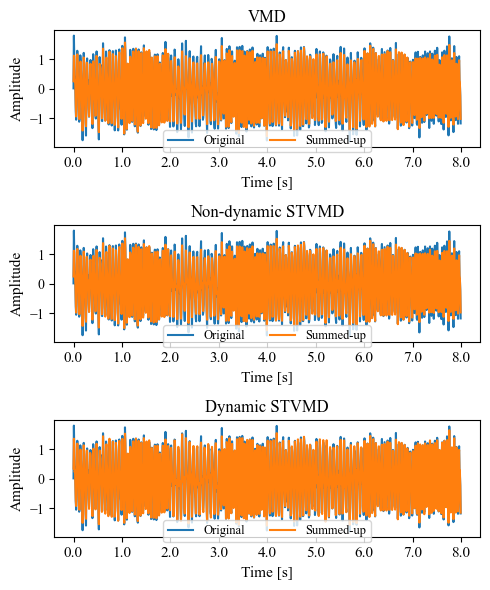

In [116]:
fig, axs = plt.subplots(3, 1, figsize=(5, 6))
axs[0].plot(f, label='Original')
axs[0].plot(imf_vmd[:,0,:].sum(0), label='Summed-up')

axs[1].plot(f, label='Original')
axs[1].plot(imf_stvmd_nd[:,0,:].sum(0), label='Summed-up')

axs[2].plot(f, label='Original')
axs[2].plot(imf_stvmd_d[:,0,:].sum(0), label='Summed-up')

title = ['VMD', 'Non-dynamic STVMD', 'Dynamic STVMD']
for i in range(3):
    axs[i].legend(ncol=2, loc='lower center', fontsize=9, bbox_to_anchor=(0.5, -0.1))
    # axs[i].set_ylim(-2.5, 1.8)
    axs[i].set_xticks(np.arange(0, N+1, fs))
    axs[i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[i].set_ylabel('Amplitude', fontsize=fontsize)
    axs[i].set_title(title[i])
fig.subplots_adjust(bottom=0.5)
plt.tight_layout()

In [117]:
N = 1024
fs = 128
t = np.arange(N)/fs
x1 = np.sin(2*np.pi*(20*t+10)*t)
x2 = 0.5*np.sin(2*np.pi*(20*t+20)*t)
np.random.seed(7)
f =x1+x2+np.random.randn(N)*0.2

In [118]:
imf_stvmd_d = []
imf_stvmd_nd = []
f_hat = []
nfft = 64
N_imfs = 3
N_channels = 1
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=64, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

window_func = scipy.signal.windows.hamming(nfft, sym=False)
stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_s, b_hat_s = stmd.prepare_offline(f)
u_hat_d, w_hat_d = stmd.apply(f_hat_s, dynamic=True)
imf_stvmd_d = stmd.postprocess(u_hat_d)
u_hat_nd, w_hat_nd = stmd.apply(f_hat_s, dynamic=False)
imf_stvmd_nd = stmd.postprocess(u_hat_nd)

Processing 0.000000001::   1%|          | 74/9999 [00:03<07:26, 22.23it/s]


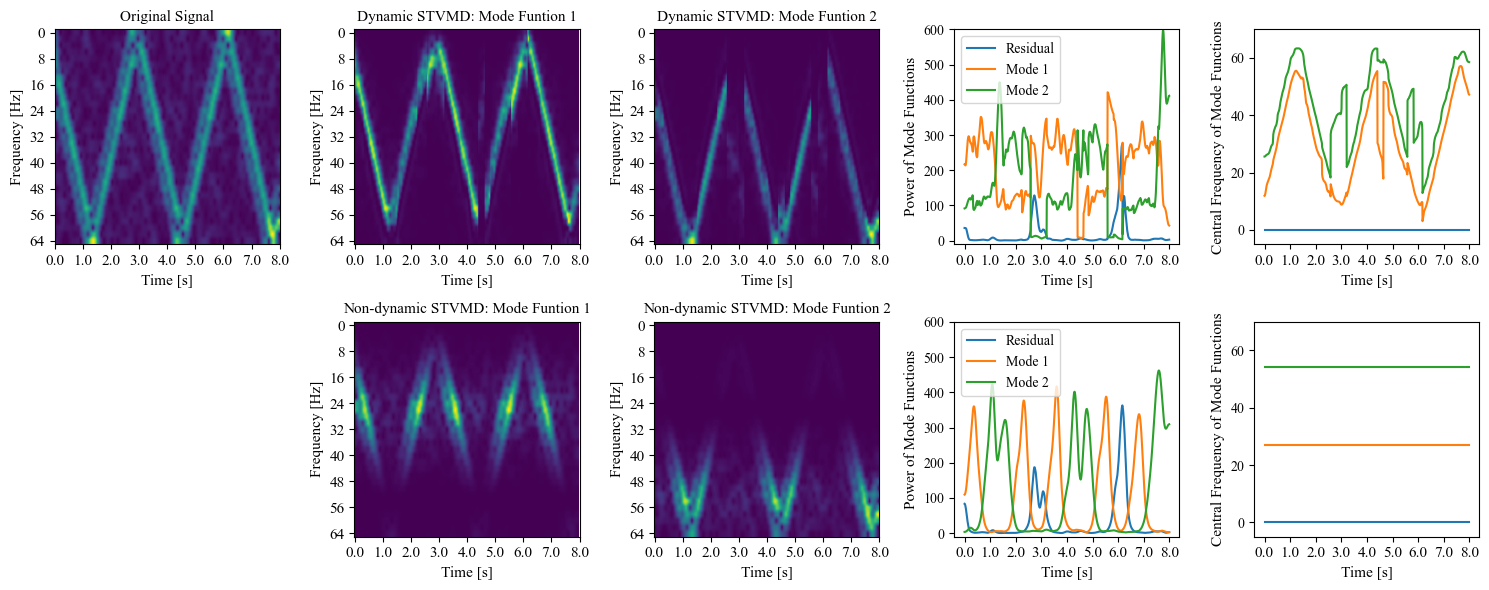

In [119]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
p_end = 33
p_step=4
scale=2
fontsize = 11
axs[0, 0].imshow(np.abs(f_hat_s[0,:p_end,:]), aspect='auto')
axs[0, 0].set_xticks(np.arange(0, N+1, fs))
axs[0, 0].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 0].set_yticks(np.arange(0, p_end, p_step))
axs[0, 0].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
axs[0, 0].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 0].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[0, 0].set_title('Original Signal', fontsize=fontsize)

for idx in range(2):
    i = idx+1
    axs[0, i].imshow(np.abs(u_hat_d[0,:,idx+1,:]), aspect='auto')
    axs[0, i].set_xticks(np.arange(0, N+1, fs))
    axs[0, i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[0, i].set_yticks(np.arange(0, p_end, p_step))
    axs[0, i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[0, i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[0, i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    if idx+1!=0:
        axs[0, i].set_title(f'Dynamic STVMD: Mode Funtion {idx+1}', fontsize=fontsize)
    else:
        axs[0, i].set_title(f'Dynamic STVMD: Residual at 0 Hz', fontsize=fontsize)
axs[0, 3].plot((u_hat_d*np.conj(u_hat_d))[0].real.sum(0).T, label=['Residual', 'Mode 1', 'Mode 2'])
axs[0, 3].set_xticks(np.arange(0, N+1, fs))
axs[0, 3].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 3].set_ylim(-10, 600)
axs[0, 3].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 3].set_ylabel('Power of Mode Functions', fontsize=fontsize)
axs[0, 3].legend(loc='upper left')

axs[0, 4].plot(w_hat_d.T*64, label=['Residual', 'Mode 1', 'Mode 2'])
axs[0, 4].set_xticks(np.arange(0, N+1, fs))
axs[0, 4].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 4].set_ylim(-5, 70)
axs[0, 4].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 4].set_ylabel('Central Frequency of Mode Functions', fontsize=fontsize)
# axs[0, 4].legend(loc='lower left')

axs[1, 0].axis('off')
for idx in range(2):
    i = idx+1
    axs[1, i].imshow(np.abs(u_hat_nd[0,:,idx+1,:]), aspect='auto')
    axs[1, i].set_xticks(np.arange(0, N+1, fs))
    axs[1, i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[1, i].set_yticks(np.arange(0, p_end, p_step))
    axs[1, i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[1, i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[1, i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    if idx+1!=0:
        axs[1, i].set_title(f'Non-dynamic STVMD: Mode Funtion {idx+1}', fontsize=fontsize)
    else:
        axs[1, i].set_title(f'Non-dynamic STVMD: Residual at 0 Hz', fontsize=fontsize)

axs[1, 3].plot((u_hat_nd*np.conj(u_hat_nd))[0].real.sum(0).T, label=['Residual', 'Mode 1', 'Mode 2'])
axs[1, 3].set_ylim(-10, 600)
axs[1, 3].set_xticks(np.arange(0, N+1, fs))
axs[1, 3].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[1, 3].set_xlabel('Time [s]', fontsize=fontsize)
axs[1, 3].set_ylabel('Power of Mode Functions', fontsize=fontsize)
axs[1, 3].legend(loc='upper left')

axs[1, 4].plot(w_hat_nd.reshape(1,-1)*np.ones((N,1))*64, label=['Residual', 'Mode 1', 'Mode 2'])
axs[1, 4].set_xticks(np.arange(0, N+1, fs))
axs[1, 4].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[1, 4].set_ylim(-5, 70)
axs[1, 4].set_xlabel('Time [s]', fontsize=fontsize)
axs[1, 4].set_ylabel('Central Frequency of Mode Functions', fontsize=fontsize)
# axs[1, 4].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [120]:
err = f - imf_vmd[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

err = f - imf_stvmd_nd[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

err = f - imf_stvmd_d[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

0.29823972006185023
0.2690992842749108
0.10581689664026142


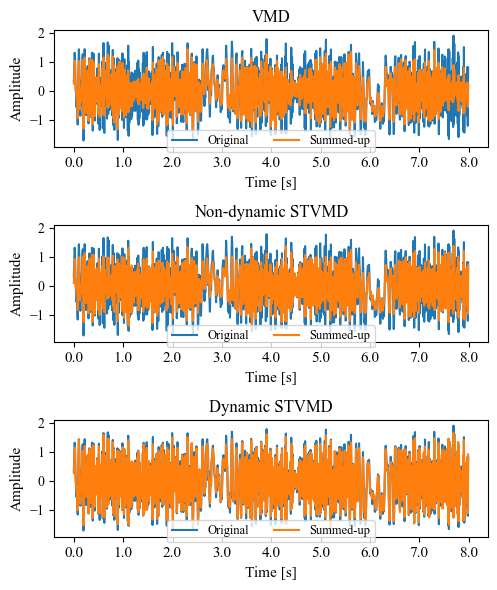

In [121]:
fig, axs = plt.subplots(3, 1, figsize=(5, 6))
axs[0].plot(f, label='Original')
axs[0].plot(imf_vmd[:,0,:].sum(0), label='Summed-up')

axs[1].plot(f, label='Original')
axs[1].plot(imf_stvmd_nd[:,0,:].sum(0), label='Summed-up')

axs[2].plot(f, label='Original')
axs[2].plot(imf_stvmd_d[:,0,:].sum(0), label='Summed-up')

title = ['VMD', 'Non-dynamic STVMD', 'Dynamic STVMD']
for i in range(3):
    axs[i].legend(ncol=2, loc='lower center', fontsize=9, bbox_to_anchor=(0.5, -0.1))
    # axs[i].set_ylim(-2.5, 1.8)
    axs[i].set_xticks(np.arange(0, N+1, fs))
    axs[i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[i].set_ylabel('Amplitude', fontsize=fontsize)
    axs[i].set_title(title[i])
fig.subplots_adjust(bottom=0.5)
plt.tight_layout()

In [122]:
N = 1024
fs = 128
t = np.arange(N)/fs
x1 = np.sin(2*np.pi*(np.sin(2*np.pi*0.25*t)*2+10)*t)
x2 = 0.5*np.sin(2*np.pi*(np.cos(2*np.pi*0.25*t)*1.5+40)*t)
np.random.seed(7)
f =x1+x2+np.random.randn(N)*0.2

In [123]:
imf_stvmd_d = []
imf_stvmd_nd = []
f_hat = []
nfft = 64
N_imfs = 3
N_channels = 1
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=64, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

window_func = scipy.signal.windows.hamming(nfft, sym=False)
stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_s, b_hat_s = stmd.prepare_offline(f)
u_hat_d, w_hat_d = stmd.apply(f_hat_s, dynamic=True)
imf_stvmd_d = stmd.postprocess(u_hat_d)
u_hat_nd, w_hat_nd = stmd.apply(f_hat_s, dynamic=False)
imf_stvmd_nd = stmd.postprocess(u_hat_nd)

Processing 0.000000001::   0%|          | 46/9999 [00:01<07:06, 23.32it/s]


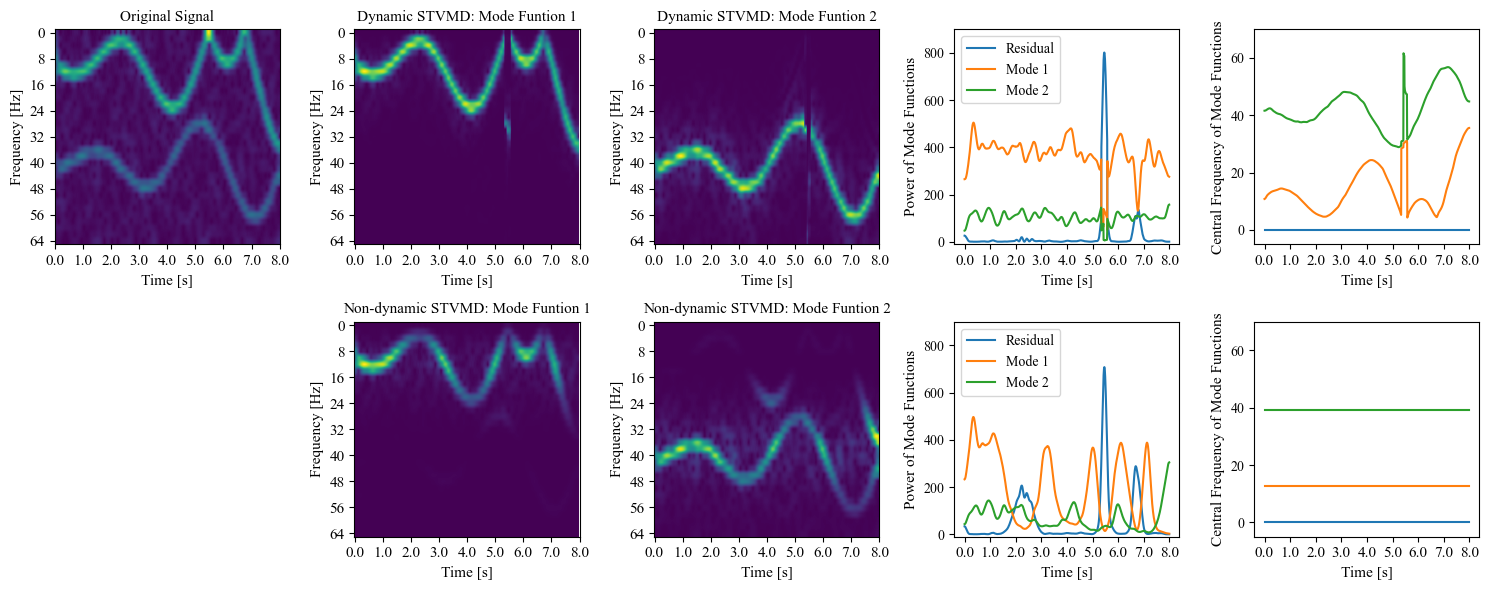

In [124]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
p_end = 33
p_step=4
scale=2
fontsize = 11
axs[0, 0].imshow(np.abs(f_hat_s[0,:p_end,:]), aspect='auto')
axs[0, 0].set_xticks(np.arange(0, N+1, fs))
axs[0, 0].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 0].set_yticks(np.arange(0, p_end, p_step))
axs[0, 0].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
axs[0, 0].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 0].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[0, 0].set_title('Original Signal', fontsize=fontsize)

for idx in range(2):
    i = idx+1
    axs[0, i].imshow(np.abs(u_hat_d[0,:,idx+1,:]), aspect='auto')
    axs[0, i].set_xticks(np.arange(0, N+1, fs))
    axs[0, i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[0, i].set_yticks(np.arange(0, p_end, p_step))
    axs[0, i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[0, i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[0, i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    if idx+1!=0:
        axs[0, i].set_title(f'Dynamic STVMD: Mode Funtion {idx+1}', fontsize=fontsize)
    else:
        axs[0, i].set_title(f'Dynamic STVMD: Residual at 0 Hz', fontsize=fontsize)
axs[0, 3].plot((u_hat_d*np.conj(u_hat_d))[0].real.sum(0).T, label=['Residual', 'Mode 1', 'Mode 2'])
axs[0, 3].set_xticks(np.arange(0, N+1, fs))
axs[0, 3].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 3].set_ylim(-10, 900)
axs[0, 3].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 3].set_ylabel('Power of Mode Functions', fontsize=fontsize)
axs[0, 3].legend(loc='upper left')

axs[0, 4].plot(w_hat_d.T*64, label=['Residual', 'Mode 1', 'Mode 2'])
axs[0, 4].set_xticks(np.arange(0, N+1, fs))
axs[0, 4].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0, 4].set_ylim(-5, 70)
axs[0, 4].set_xlabel('Time [s]', fontsize=fontsize)
axs[0, 4].set_ylabel('Central Frequency of Mode Functions', fontsize=fontsize)
# axs[0, 4].legend(loc='lower left')

axs[1, 0].axis('off')
for idx in range(2):
    i = idx+1
    axs[1, i].imshow(np.abs(u_hat_nd[0,:,idx+1,:]), aspect='auto')
    axs[1, i].set_xticks(np.arange(0, N+1, fs))
    axs[1, i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[1, i].set_yticks(np.arange(0, p_end, p_step))
    axs[1, i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[1, i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[1, i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    if idx+1!=0:
        axs[1, i].set_title(f'Non-dynamic STVMD: Mode Funtion {idx+1}', fontsize=fontsize)
    else:
        axs[1, i].set_title(f'Non-dynamic STVMD: Residual at 0 Hz', fontsize=fontsize)

axs[1, 3].plot((u_hat_nd*np.conj(u_hat_nd))[0].real.sum(0).T, label=['Residual', 'Mode 1', 'Mode 2'])
axs[1, 3].set_ylim(-10, 900)
axs[1, 3].set_xticks(np.arange(0, N+1, fs))
axs[1, 3].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[1, 3].set_xlabel('Time [s]', fontsize=fontsize)
axs[1, 3].set_ylabel('Power of Mode Functions', fontsize=fontsize)
axs[1, 3].legend(loc='upper left')

axs[1, 4].plot(w_hat_nd.reshape(1,-1)*np.ones((N,1))*64, label=['Residual', 'Mode 1', 'Mode 2'])
axs[1, 4].set_xticks(np.arange(0, N+1, fs))
axs[1, 4].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[1, 4].set_ylim(-5, 70)
axs[1, 4].set_xlabel('Time [s]', fontsize=fontsize)
axs[1, 4].set_ylabel('Central Frequency of Mode Functions', fontsize=fontsize)

plt.tight_layout()
plt.show()

In [125]:
err = f - imf_vmd[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

err = f - imf_stvmd_nd[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

err = f - imf_stvmd_d[:,0,:].sum(0)
print(np.sqrt(np.mean(np.power(err, 2))))

0.22272300257866523
0.22361903000272845
0.08861046834279153


In [126]:
a = [0.1239, 0.2982, 0.2227]
b = [0.1220, 0.2691, 0.2236]
c = [0.0950, 0.1058, 0.0886]
print(np.mean(a))
print(np.mean(b))
print(np.mean(c))

0.21493333333333334
0.2049
0.09646666666666666


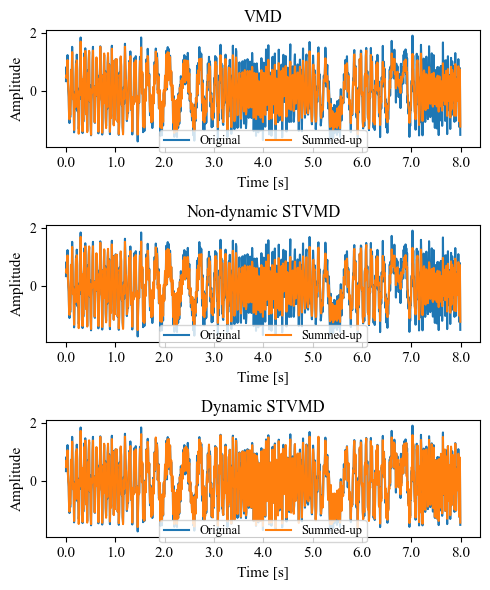

In [127]:
fig, axs = plt.subplots(3, 1, figsize=(5, 6))
axs[0].plot(f, label='Original')
axs[0].plot(imf_vmd[:,0,:].sum(0), label='Summed-up')

axs[1].plot(f, label='Original')
axs[1].plot(imf_stvmd_nd[:,0,:].sum(0), label='Summed-up')

axs[2].plot(f, label='Original')
axs[2].plot(imf_stvmd_d[:,0,:].sum(0), label='Summed-up')

title = ['VMD', 'Non-dynamic STVMD', 'Dynamic STVMD']
for i in range(3):
    axs[i].legend(ncol=2, loc='lower center', fontsize=9, bbox_to_anchor=(0.5, -0.1))
    # axs[i].set_ylim(-2.5, 1.8)
    axs[i].set_xticks(np.arange(0, N+1, fs))
    axs[i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[i].set_ylabel('Amplitude', fontsize=fontsize)
    axs[i].set_title(title[i])
fig.subplots_adjust(bottom=0.5)
plt.tight_layout()
plt.show()

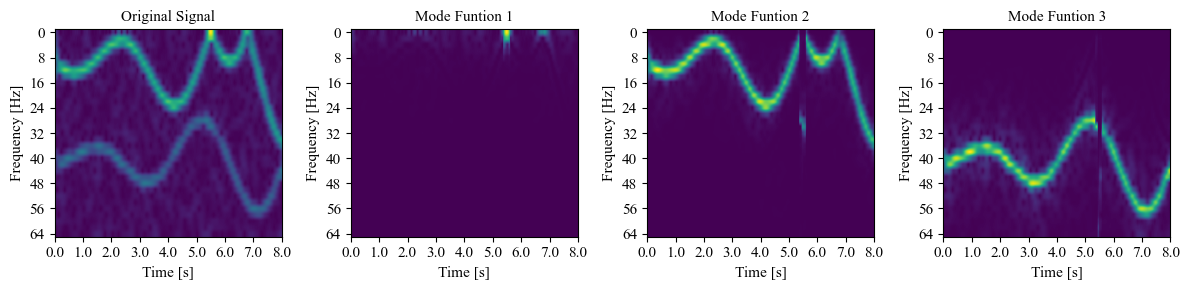

In [128]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
p_end = 33
p_step=4
scale=2
fontsize = 11
axs[0].imshow(np.abs(f_hat_s[0,:p_end,:]), aspect='auto')
axs[0].set_xticks(np.arange(0, N+1, fs))
axs[0].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0].set_yticks(np.arange(0, p_end, p_step))
axs[0].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
axs[0].set_xlabel('Time [s]', fontsize=fontsize)
axs[0].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[0].set_title('Original Signal', fontsize=fontsize)

for idx in range(3):
    i = idx+1
    axs[i].imshow(np.abs(u_hat_d[0,:,idx,:]), aspect='auto')
    axs[i].set_xticks(np.arange(0, N+1, fs))
    axs[i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[i].set_yticks(np.arange(0, p_end, p_step))
    axs[i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    axs[i].set_title(f'Mode Funtion {i}', fontsize=fontsize)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()

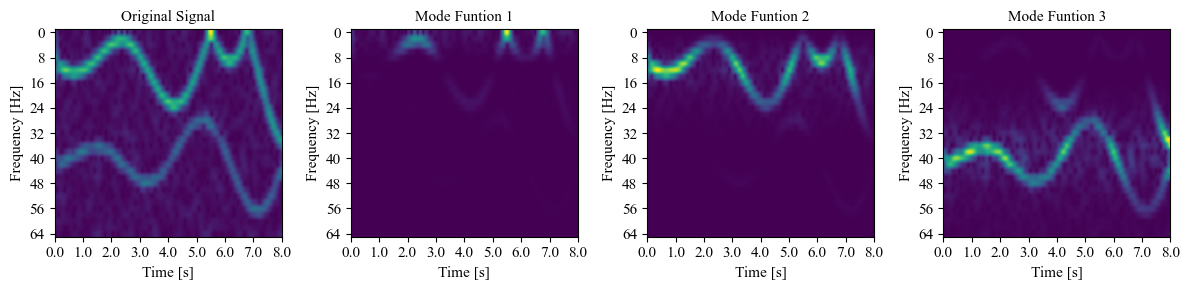

In [129]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
p_end = 33
p_step=4
scale=2
fontsize = 11
axs[0].imshow(np.abs(f_hat_s[0,:p_end,:]), aspect='auto')
axs[0].set_xticks(np.arange(0, N+1, fs))
axs[0].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0].set_yticks(np.arange(0, p_end, p_step))
axs[0].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
axs[0].set_xlabel('Time [s]', fontsize=fontsize)
axs[0].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[0].set_title('Original Signal', fontsize=fontsize)

for idx in range(3):
    i = idx+1
    axs[i].imshow(np.abs(u_hat_nd[0,:,idx,:]), aspect='auto')
    axs[i].set_xticks(np.arange(0, N+1, fs))
    axs[i].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[i].set_yticks(np.arange(0, p_end, p_step))
    axs[i].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    axs[i].set_xlabel('Time [s]', fontsize=fontsize)
    axs[i].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    axs[i].set_title(f'Mode Funtion {i}', fontsize=fontsize)
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()

In [130]:
N = 128
fs = 128
t = np.arange(N)/fs
np.random.seed(3196)
x1 = np.sin(2*np.pi*20*t)
x2 = 0.5*np.sin(2*np.pi*28*t)
x3 = 0.5*np.sin(2*np.pi*48*t)
f1 =x1+x2+x3

x1 = np.sin(2*np.pi*15*t)
x2 = 0.5*np.sin(2*np.pi*36*t)
x3 = 0.5*np.sin(2*np.pi*42*t)
f2 =x1+x2+x3

f = np.concatenate((f1, f2), axis=0)

In [131]:
N_fft = 64 # This is used for padding
N_imfs = 4
N_channels = 1
alpha = 50
vmd = VMD(num_channel=N_channels, alpha=alpha, n_fft=N_fft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_v = vmd.prepare_offline(f)
u_hat_v, w_hat_v = vmd.apply(f_hat_v)
imf_vmd = vmd.postprocess(u_hat_v)

Processing 0.000000001::   0%|          | 7/9999 [00:00<00:22, 444.25it/s]


In [132]:
imf_stvmds = []
imf_stvmds.append(imf_vmd)
N_fft = [128]
for idx, nfft in enumerate(N_fft):
    window_func = scipy.signal.windows.hamming(nfft, sym=True)
    stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
    f_hat_s, b_hat_s = stmd.prepare_offline(f)
    u_hat_s, w_hat_s = stmd.apply(f_hat_s, dynamic=True)
    imf_stvmd = stmd.postprocess(u_hat_s)
    imf_stvmds.append(imf_stvmd)

Processing 0.000000001::   1%|          | 100/9999 [00:02<04:06, 40.16it/s]


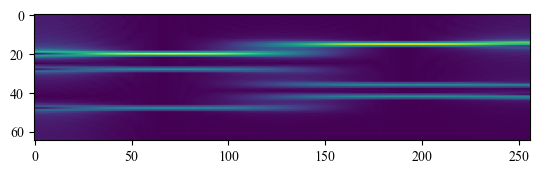

In [133]:
plt.imshow(np.abs(f_hat_s[0]))

In [134]:
imf_stvmds[0].shape

(4, 1, 256)

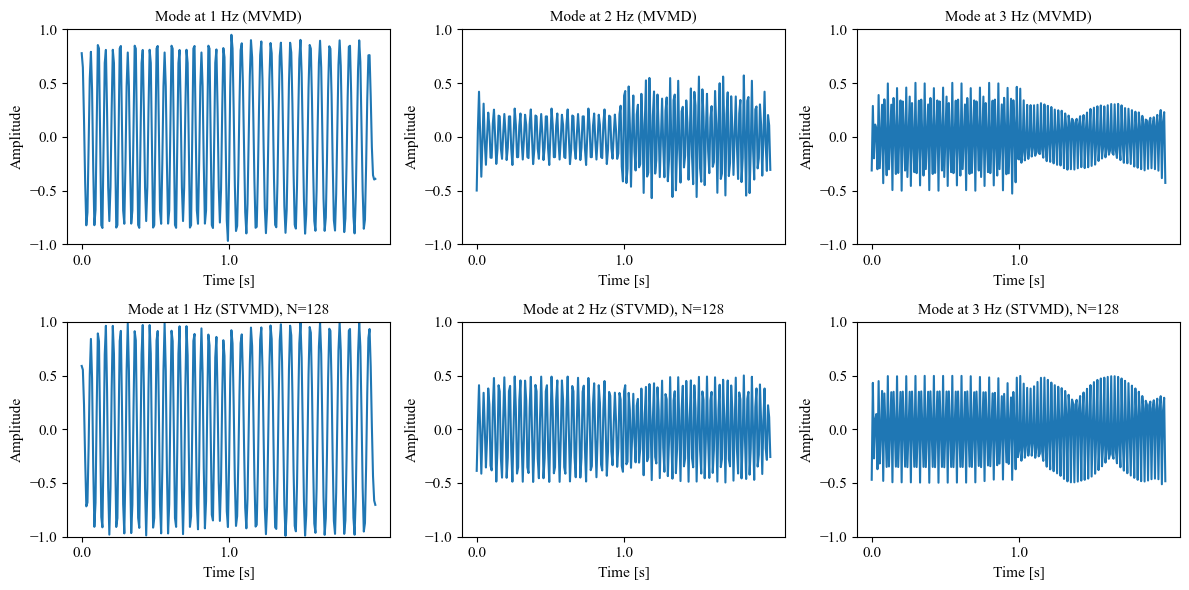

In [135]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
lim=1
freq = [1, 2, 3]
fontsize = 11
for i in np.arange(2):
    for j in np.arange(3):
        axs[i,j].plot(imf_stvmds[i][j+1, 0, :], label='STVMD')
        axs[i,j].set_xticks(np.arange(0, N+1, fs))
        axs[i,j].set_xticklabels(np.arange(0, N+1, fs)/fs)
        axs[i,j].set_ylim((-lim,lim))
        axs[i,j].set_xlabel('Time [s]', fontsize=fontsize)
        axs[i,j].set_ylabel('Amplitude', fontsize=fontsize)
        axs[i,j].tick_params(axis='both', which='major', labelsize=fontsize)
        if i==0:
            axs[i,j].set_title(f'Mode at {freq[j]} Hz (MVMD)', fontsize=fontsize)
        else:
            axs[i,j].set_title(f'Mode at {freq[j]} Hz (STVMD), N={N_fft[i-1]}', fontsize=fontsize)
        
        
# Display the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()


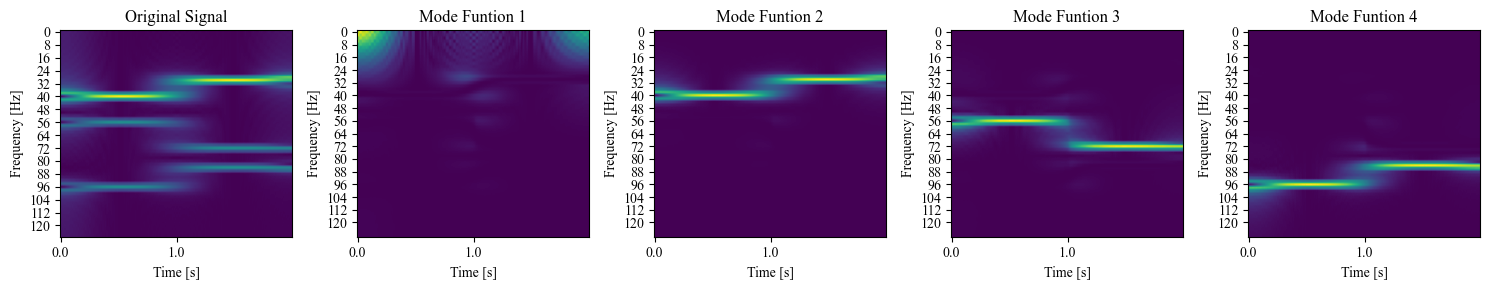

In [136]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
p_end = 64
p_step=4
scale=2

axs[0].imshow(np.abs(f_hat_s[0,:p_end,:]), aspect='auto')
axs[0].set_xticks(np.arange(0, N+1, fs))
axs[0].set_xticklabels(np.arange(0, N+1, fs)/fs)
axs[0].set_yticks(np.arange(0, p_end, p_step))
axs[0].set_yticklabels(np.arange(0, p_end, p_step)*scale)
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Frequency [Hz]')
axs[0].set_title('Original Signal')

for idx in range(4):
    i = idx+1
    axs[i].imshow(np.abs(u_hat_s[0,:,idx,:]), aspect='auto')
    axs[i].set_xticks(np.arange(0, N+1, fs))
    axs[i].set_xticklabels(np.arange(0, N+1, fs)/fs)
    axs[i].set_yticks(np.arange(0, p_end, p_step))
    axs[i].set_yticklabels(np.arange(0, p_end, p_step)*scale)
    axs[i].set_xlabel('Time [s]')
    axs[i].set_ylabel('Frequency [Hz]')
    axs[i].set_title(f'Mode Funtion {i}')
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()


In [137]:
N = 1024
fs = 128
t = np.arange(N)/fs
np.random.seed(7)
seq = np.random.permutation(np.arange(8))
def omega(t):
    return seq[np.floor(t).astype(int)]+13

# t10 = omega(t)/2
# x10 = 2*np.sin(2*np.pi*t*t10)
t11 = omega(t)
x11 = 1*np.sin(2*np.pi*t*t11)
t12 = 2*omega(t)
x12 = 0.5*np.sin(2*np.pi*t*t12)

# t20 = omega(t)/2
# x20 = 2*np.sin(2*np.pi*t*t20)
t21 = omega(t)
x21 = 1*np.cos(2*np.pi*t*t21)
t22 = 3*omega(t)
x22 = 0.5*np.sin(2*np.pi*t*t22)

f1 =x11+x12+np.random.randn(N)*0.2
f2 =x21+x22+np.random.randn(N)*0.2
f = np.concatenate((f1.reshape(1,-1), f2.reshape(1,-1)),axis=0)

In [139]:
imf_stvmd_d = []
imf_stvmd_nd = []
f_hat = []
nfft = 64
N_imfs = 4
N_channels = 2
alpha = 50

window_func = scipy.signal.windows.hamming(nfft, sym=False)
stmd = STVMD(num_channel=N_channels, window_func=window_func, alpha=alpha, n_fft=nfft, K=N_imfs, tol=1e-9, tau=0.00001, maxiters=10000)
f_hat_s, b_hat_s = stmd.prepare_offline(f)
u_hat_d, w_hat_d = stmd.apply(f_hat_s, dynamic=True)
imf_stvmd_d = stmd.postprocess(u_hat_d)

Processing 0.000000001::   1%|          | 123/9999 [00:18<24:20,  6.76it/s]


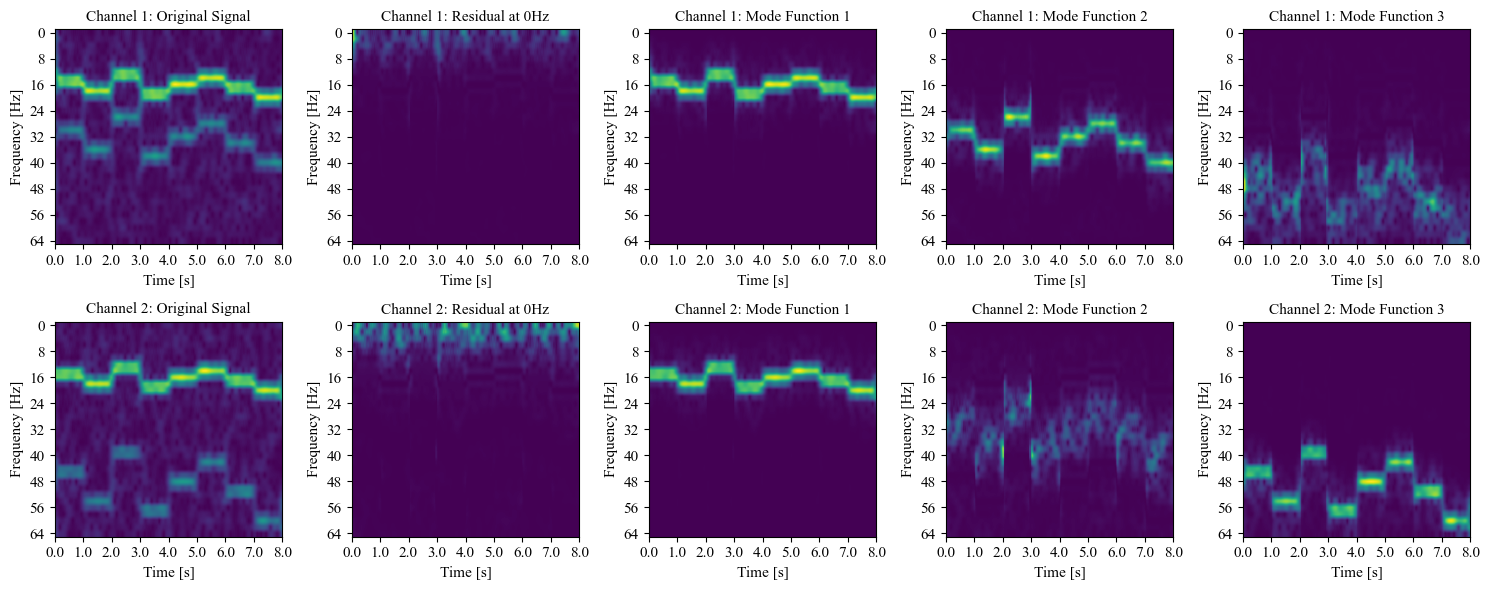

In [141]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
p_end = 33
p_step=4
scale=2
fontsize = 11
for ch in range(2):
    axs[ch, 0].imshow(np.abs(f_hat_s[ch]), aspect='auto')
    axs[ch, 0].set_xlabel('Time [s]', fontsize=fontsize)
    axs[ch, 0].set_ylabel('Frequency [Hz]', fontsize=fontsize)
    axs[ch, 0].set_title(f'Channel {ch+1}: Original Signal', fontsize=fontsize)
    axs[ch, 0].set_xticks(np.arange(0, N+1, fs))
    axs[ch, 0].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
    axs[ch, 0].set_yticks(np.arange(0, p_end, p_step))
    axs[ch, 0].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
    for imf in range(4):
        axs[ch, imf+1].imshow(np.abs(u_hat_d[ch, :, imf, :]), aspect='auto')
        axs[ch, imf+1].set_xlabel('Time [s]', fontsize=fontsize)
        axs[ch, imf+1].set_ylabel('Frequency [Hz]', fontsize=fontsize)
        if imf==0:
            axs[ch, imf+1].set_title(f'Channel {ch+1}: Residual at 0Hz', fontsize=fontsize)
        else:
            axs[ch, imf+1].set_title(f'Channel {ch+1}: Mode Function {imf}', fontsize=fontsize)
        axs[ch, imf+1].set_xticks(np.arange(0, N+1, fs))
        axs[ch, imf+1].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
        axs[ch, imf+1].set_yticks(np.arange(0, p_end, p_step))
        axs[ch, imf+1].set_yticklabels(np.arange(0, p_end, p_step)*scale, fontsize=fontsize)
plt.tight_layout()
plt.show()

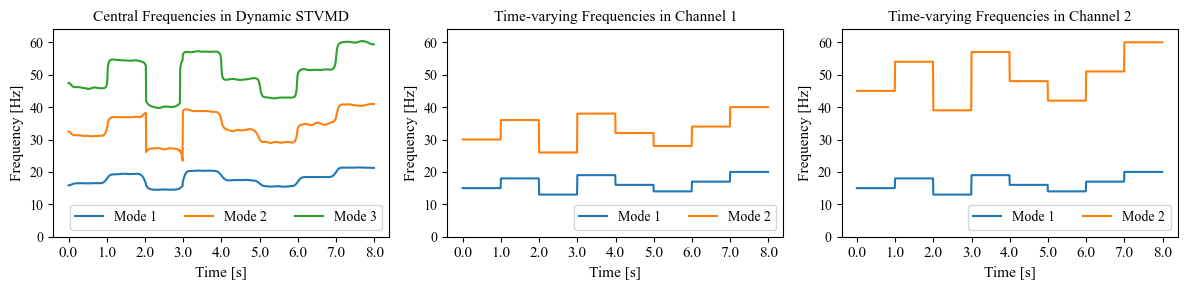

In [143]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(w_hat_d[1:].T*64, label=['Mode 1','Mode 2','Mode 3'])
axs[0].set_ylim(0, 64)
axs[0].set_xlabel('Time [s]', fontsize=fontsize)
axs[0].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[0].set_xticks(np.arange(0, N+1, fs))
axs[0].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[0].legend(loc='lower right', ncol=3, fontsize=fontsize-1)
axs[0].set_title('Central Frequencies in Dynamic STVMD', fontsize=fontsize)

axs[1].plot(t11, label='Mode 1')
axs[1].plot(t12, label='Mode 2')
axs[1].set_ylim(0, 64)
axs[1].set_xlabel('Time [s]', fontsize=fontsize)
axs[1].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[1].set_xticks(np.arange(0, N+1, fs))
axs[1].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[1].legend(loc='lower right', ncol=2, fontsize=fontsize-1)
axs[1].set_title('Time-varying Frequencies in Channel 1', fontsize=fontsize)

axs[2].plot(t21, label='Mode 1')
axs[2].plot(t22, label='Mode 2')
axs[2].set_ylim(0, 64)
axs[2].set_xlabel('Time [s]', fontsize=fontsize)
axs[2].set_ylabel('Frequency [Hz]', fontsize=fontsize)
axs[2].set_xticks(np.arange(0, N+1, fs))
axs[2].set_xticklabels(np.arange(0, N+1, fs)/fs, fontsize=fontsize)
axs[2].legend(loc='lower right', ncol=2, fontsize=fontsize-1)
axs[2].set_title('Time-varying Frequencies in Channel 2', fontsize=fontsize)

plt.tight_layout()
plt.show()